# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Data Loaders

In [2]:
# Loading the train dataset
data = pd.read_csv('train.csv')

#Remove rows with mising values
data.dropna(inplace=True)
data

ID    YEAR   T2M_RANGE    T2M_MAX    T2M_MIN       RH2M         PS  \
0        0  1982.0 -241.552430  29.798545  13.691128  71.652934  89.725069   
1        1  1982.0 -241.819997  30.902708  15.298046  69.754933  89.865668   
2        2  1982.0 -241.883202  30.296561  14.660419  66.661416  89.846273   
3        3  1982.0 -242.007629  30.803224  15.246491  67.621173  90.029795   
4        4  1982.0 -240.659332  32.500906  15.303059  62.097329  89.825707   
...    ...     ...         ...        ...        ...        ...        ...   
1434  1434  2009.0 -246.654914  30.644813  20.268662  78.611410  89.333566   
1435  1435  2009.0 -247.651283  29.857874  20.425241  78.136636  89.324790   
1436  1436  2009.0 -247.594571  30.330303  21.123513  77.497787  89.334675   
1437  1437  2009.0 -247.083708  30.646652  20.883603  75.857655  89.465743   
1438  1438  2009.0 -246.099233  32.191877  21.121979  75.757341  89.528083   

         WS10M       QV2M        T2M  VACATION_RATE  
0     3.658959   8.474319  21.723403      64.184741  
1     3.529113   8.988374  22.911522      42.649137  
2     4.217007   8.474923  22.994887      52.819141  
3     4.484080   9.005508  23.594655      39.445489  
4     3.057211   8.307515  24.536776      46.444289  
...        ...        ...        ...            ...  
1434  6.433604  13.258977  26.685352       6.391643  
1435  7.638996  12.717079  25.991700       1.920453  
1436  8.939772  13.058350  26.619025       7.144639  
1437  7.663743  12.805387  26.923294       4.886901  
1438  6.426315  13.028215  27.318661      11.217462  

[1439 rows x 11 columns]

In [3]:
# Loading the final validation dataset
test = pd.read_csv('test.csv')
test

ID    YEAR   T2M_RANGE    T2M_MAX    T2M_MIN       RH2M         PS  \
0    1440  2009.0 -309.569706  32.919144  17.735611  74.415249  82.443918   
1    1441  2009.0 -310.763533  32.340370  17.955298  75.232482  82.320169   
2    1442  2009.0 -313.096292  29.670217  17.788919  80.950265  82.456590   
3    1443  2009.0 -312.110915  29.586632  16.777071  82.254238  82.460926   
4    1444  2009.0 -312.445008  30.088295  17.233512  81.311915  82.326908   
..    ...     ...         ...        ...        ...        ...        ...   
695  2135  2022.0 -310.857597  28.357413  15.023100  86.599317  82.511107   
696  2136  2022.0 -312.033878  26.943856  14.236847  85.965911  82.748450   
697  2137  2022.0 -312.869384  26.542410  14.972372  88.082615  82.626626   
698  2138  2022.0 -308.938303  27.599339  12.882619  84.585012  82.632252   
699  2139  2022.0 -310.589598  28.341680  14.604535  85.173914  82.874200   

        WS10M  
0    6.513046  
1    5.163099  
2    3.974139  
3    5.504794  
4    5.634695  
..        ...  
695  2.637025  
696  3.636588  
697  3.840101  
698  3.306362  
699  3.522586  

[700 rows x 8 columns]

In order to select the right features to make more accurate predictions, I am plotting scatter plots of feature vs feature and features vs label, and also plotting a correlation table. The main thing here is that the feature-feature correlation must be minimal and feature-label correlation must be maximum in order to have minimal noise. On looking at the plots and analysing the dependency and correlation between them, i have prioritized some features for training. Two important things to watch out for in a multiple regression problem like this are overfitting and multicollinearity. Overfitting is an undesirable machine learning behavior that occurs when the machine learning model gives accurate predictions for training data but not for new data (basically it memorizes). Multicollinearity happens when independent variables in the regression model are highly correlated to each other.

# Feature Engineering

In [4]:
processed_data = data
processed_test = test

In [5]:
# Feature engineering
processed_data['T2M_RANGE_SQUARED'] = data['T2M_RANGE'] ** 2
processed_data['T2M_MIN_RH_INTERACTION'] = data['T2M_MIN'] * data['RH2M']
processed_data['PS_DIFF'] = data['PS'] - data['PS'].shift(1)
# processed_data

### Vacation Rates are seasonal => maybe they are correlated with which week of the year it is (Try to find more features like this)
# mapping it to the week number in a year 
num_of_weeks_in_a_year = 52
processed_data['ID_MOD'] = data['ID'].mod(num_of_weeks_in_a_year)

In [6]:
# Feature engineering for test data
processed_test['T2M_RANGE_SQUARED'] = test['T2M_RANGE'] ** 2
processed_test['T2M_MIN_RH_INTERACTION'] = test['T2M_MIN'] * test['RH2M']
processed_test['PS_DIFF'] = test['PS'] - test['PS'].shift(1)

num_of_weeks_in_a_year = 52
processed_test['ID_MOD'] = test['ID'].mod(num_of_weeks_in_a_year)

In [7]:
processed_test.dropna(inplace=True)
processed_data.dropna(inplace=True)

# Feature Analysis

In [8]:
processed_data

ID    YEAR   T2M_RANGE    T2M_MAX    T2M_MIN       RH2M         PS  \
1        1  1982.0 -241.819997  30.902708  15.298046  69.754933  89.865668   
2        2  1982.0 -241.883202  30.296561  14.660419  66.661416  89.846273   
3        3  1982.0 -242.007629  30.803224  15.246491  67.621173  90.029795   
4        4  1982.0 -240.659332  32.500906  15.303059  62.097329  89.825707   
5        5  1982.0 -239.536919  34.364785  15.924114  57.195583  89.764712   
...    ...     ...         ...        ...        ...        ...        ...   
1434  1434  2009.0 -246.654914  30.644813  20.268662  78.611410  89.333566   
1435  1435  2009.0 -247.651283  29.857874  20.425241  78.136636  89.324790   
1436  1436  2009.0 -247.594571  30.330303  21.123513  77.497787  89.334675   
1437  1437  2009.0 -247.083708  30.646652  20.883603  75.857655  89.465743   
1438  1438  2009.0 -246.099233  32.191877  21.121979  75.757341  89.528083   

         WS10M       QV2M        T2M  VACATION_RATE  T2M_RANGE_SQUARED  \
1     3.529113   8.988374  22.911522      42.649137       58476.911180   
2     4.217007   8.474923  22.994887      52.819141       58507.483271   
3     4.484080   9.005508  23.594655      39.445489       58567.692575   
4     3.057211   8.307515  24.536776      46.444289       57916.914295   
5     3.709700   8.521318  26.431056      29.495610       57377.935546   
...        ...        ...        ...            ...                ...   
1434  6.433604  13.258977  26.685352       6.391643       60838.646365   
1435  7.638996  12.717079  25.991700       1.920453       61331.157998   
1436  8.939772  13.058350  26.619025       7.144639       61303.071365   
1437  7.663743  12.805387  26.923294       4.886901       61050.358709   
1438  6.426315  13.028215  27.318661      11.217462       60564.832506   

      T2M_MIN_RH_INTERACTION   PS_DIFF  ID_MOD  
1                1067.114175  0.140600       1  
2                 977.284319 -0.019395       2  
3                1030.985614  0.183522       3  
4                 950.279090 -0.204087       4  
5                 910.789013 -0.060995       5  
...                      ...       ...     ...  
1434             1593.348072 -0.002372      30  
1435             1595.959602 -0.008777      31  
1436             1637.025536  0.009885      32  
1437             1584.181173  0.131068      33  
1438             1600.144978  0.062340      34  

[1438 rows x 15 columns]

In [9]:
# @title Statistical Insights
processed_data.describe()

ID         YEAR    T2M_RANGE      T2M_MAX      T2M_MIN  \
count  1438.000000  1438.000000  1438.000000  1438.000000  1438.000000   
mean    719.500000  1995.306676  -244.208070    32.590664    19.512153   
std     415.259156     7.962410     3.466908     4.019145     2.929380   
min       1.000000  1982.000000  -250.797410    25.301324    10.348813   
25%     360.250000  1988.000000  -247.085769    29.413759    17.666548   
50%     719.500000  1995.000000  -245.009729    31.388604    20.212155   
75%    1078.750000  2002.000000  -241.426498    35.585111    21.390229   
max    1438.000000  2009.000000  -235.262673    42.524543    26.114388   

              RH2M           PS        WS10M         QV2M          T2M  \
count  1438.000000  1438.000000  1438.000000  1438.000000  1438.000000   
mean     68.195619    89.571010     4.165363    11.194958    27.232025   
std      16.264025     0.248708     1.453486     2.514413     3.365681   
min      24.335685    88.908008     1.565365     3.793170    19.223138   
25%      55.788944    89.377572     3.143118     9.115524    25.169197   
50%      73.929857    89.553090     3.832613    12.109270    26.600389   
75%      80.613076    89.759216     4.775940    13.244736    29.083436   
max      93.728038    90.267493     9.222617    15.113460    36.215568   

       VACATION_RATE  T2M_RANGE_SQUARED  T2M_MIN_RH_INTERACTION      PS_DIFF  \
count    1438.000000        1438.000000             1438.000000  1438.000000   
mean       22.384562       59649.592405             1327.984939    -0.000137   
std        26.812566        1687.705410              365.601175     0.192735   
min        -0.121989       55348.525530              410.072572    -0.604286   
25%         4.079609       58286.753940             1007.223007    -0.132318   
50%        11.781465       60029.767254             1429.357619    -0.000478   
75%        31.475794       61051.377377             1636.437084     0.126462   
max       185.363264       62899.341100             1962.778644     0.701711   

            ID_MOD  
count  1438.000000  
mean     25.310848  
std      14.961050  
min       0.000000  
25%      12.000000  
50%      25.000000  
75%      38.000000  
max      51.000000

In [10]:
# @title Feature Correlations
processed_data.corr()

ID      YEAR  T2M_RANGE   T2M_MAX   T2M_MIN  \
ID                      1.000000  0.999345  -0.075808 -0.082733 -0.007342   
YEAR                    0.999345  1.000000  -0.054263 -0.059694 -0.005257   
T2M_RANGE              -0.075808 -0.054263   1.000000  0.727206 -0.365984   
T2M_MAX                -0.082733 -0.059694   0.727206  1.000000  0.371239   
T2M_MIN                -0.007342 -0.005257  -0.365984  0.371239  1.000000   
RH2M                    0.112742  0.088433  -0.886516 -0.926127 -0.055836   
PS                      0.011731  0.012505   0.423478 -0.065032 -0.660045   
WS10M                  -0.040356 -0.041716  -0.263943 -0.178538  0.115033   
QV2M                    0.106128  0.087681  -0.940366 -0.552273  0.524316   
T2M                    -0.054148 -0.037563   0.303263  0.871087  0.771189   
VACATION_RATE           0.053477  0.064963   0.562326  0.164562 -0.538514   
T2M_RANGE_SQUARED       0.076201  0.054674  -0.999976 -0.727645  0.365351   
T2M_MIN_RH_INTERACTION  0.098191  0.078637  -0.969163 -0.639458  0.445348   
PS_DIFF                 0.000694 -0.003093  -0.076397 -0.111146 -0.046590   
ID_MOD                  0.010392 -0.016930  -0.647231 -0.515408  0.175829   

                            RH2M        PS     WS10M      QV2M       T2M  \
ID                      0.112742  0.011731 -0.040356  0.106128 -0.054148   
YEAR                    0.088433  0.012505 -0.041716  0.087681 -0.037563   
T2M_RANGE              -0.886516  0.423478 -0.263943 -0.940366  0.303263   
T2M_MAX                -0.926127 -0.065032 -0.178538 -0.552273  0.871087   
T2M_MIN                -0.055836 -0.660045  0.115033  0.524316  0.771189   
RH2M                    1.000000 -0.161142  0.226610  0.809444 -0.664637   
PS                     -0.161142  1.000000 -0.378284 -0.527400 -0.381613   
WS10M                   0.226610 -0.378284  1.000000  0.243619 -0.094938   
QV2M                    0.809444 -0.527400  0.243619  1.000000 -0.108947   
T2M                    -0.664637 -0.381613 -0.094938 -0.108947  1.000000   
VACATION_RATE          -0.370961  0.329379 -0.163790 -0.579497 -0.171566   
T2M_RANGE_SQUARED       0.886371 -0.424289  0.264360  0.939719 -0.303684   
T2M_MIN_RH_INTERACTION  0.861794 -0.494767  0.284344  0.985688 -0.209939   
PS_DIFF                 0.103534  0.387314  0.001500  0.060697 -0.098462   
ID_MOD                  0.621471 -0.218455  0.076707  0.610310 -0.250135   

                        VACATION_RATE  T2M_RANGE_SQUARED  \
ID                           0.053477           0.076201   
YEAR                         0.064963           0.054674   
T2M_RANGE                    0.562326          -0.999976   
T2M_MAX                      0.164562          -0.727645   
T2M_MIN                     -0.538514           0.365351   
RH2M                        -0.370961           0.886371   
PS                           0.329379          -0.424289   
WS10M                       -0.163790           0.264360   
QV2M                        -0.579497           0.939719   
T2M                         -0.171566          -0.303684   
VACATION_RATE                1.000000          -0.560001   
T2M_RANGE_SQUARED           -0.560001           1.000000   
T2M_MIN_RH_INTERACTION      -0.554832           0.969193   
PS_DIFF                     -0.073768           0.075861   
ID_MOD                      -0.422222           0.647457   

                        T2M_MIN_RH_INTERACTION   PS_DIFF    ID_MOD  
ID                                    0.098191  0.000694  0.010392  
YEAR                                  0.078637 -0.003093 -0.016930  
T2M_RANGE                            -0.969163 -0.076397 -0.647231  
T2M_MAX                              -0.639458 -0.111146 -0.515408  
T2M_MIN                               0.445348 -0.046590  0.175829  
RH2M                                  0.861794  0.103534  0.621471  
PS                                   -0.494767  0.387314 -0.218455  
WS10M                                 0.284344  0.001500  0.076707 

## Scatter Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


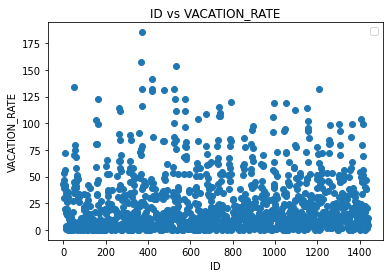

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


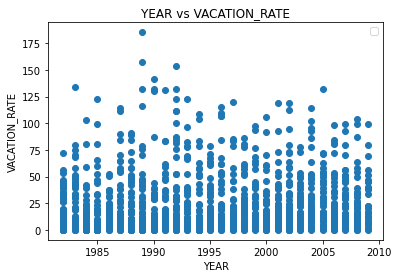

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


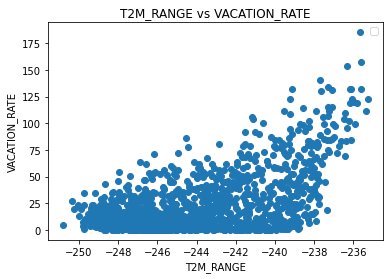

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


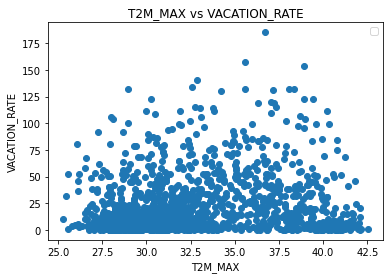

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


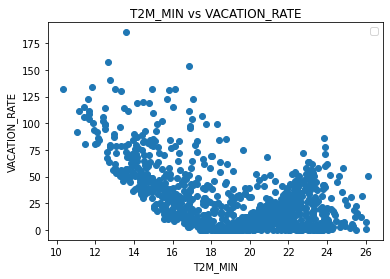

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


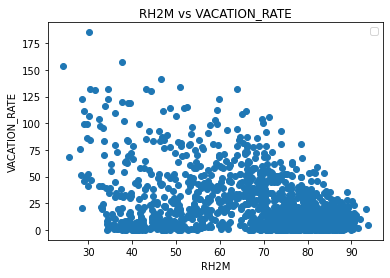

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


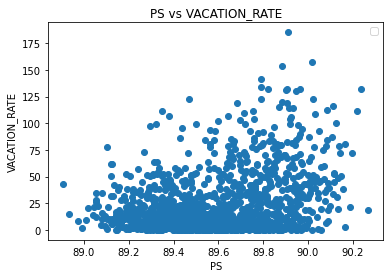

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


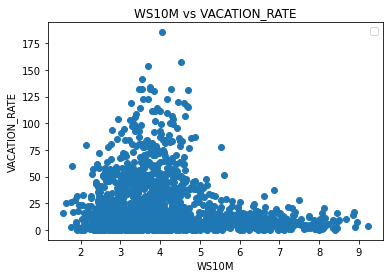

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


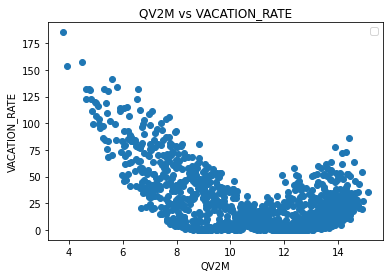

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


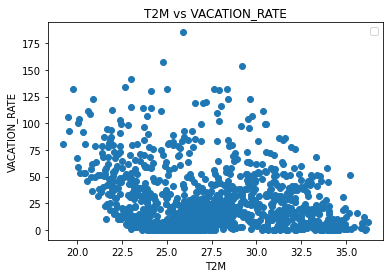

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


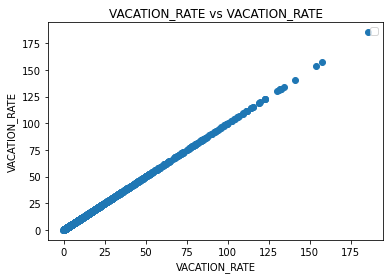

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


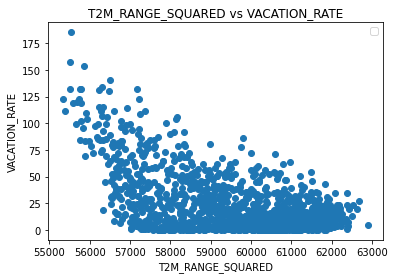

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


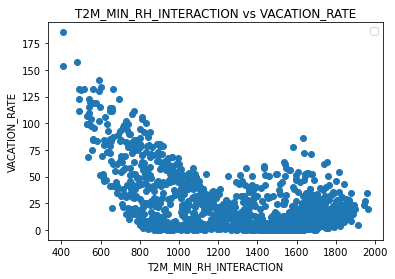

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


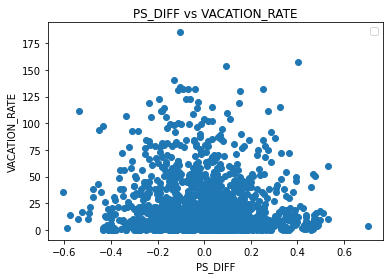

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


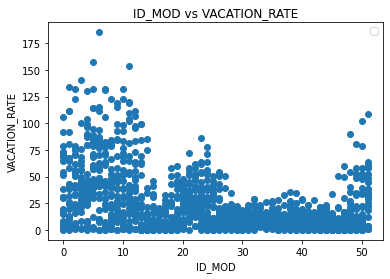

In [11]:
# @title Scatter Plots VACATION_RATE vs. Features
y_col = 'VACATION_RATE'
for x_col in processed_data.columns:
    figure = plt.figure
    ax = plt.gca()
    ax.scatter(processed_data[x_col], processed_data[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


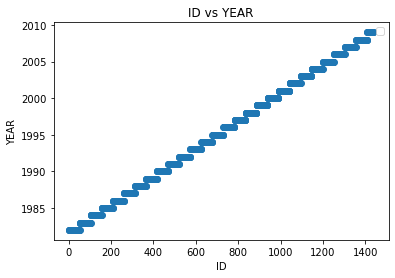

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


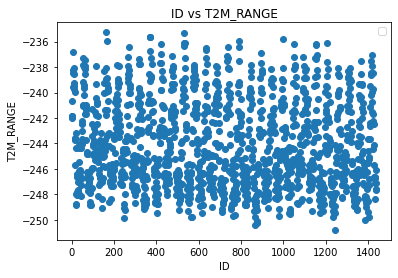

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


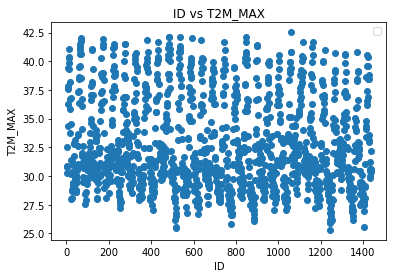

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


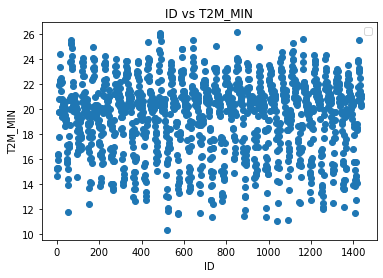

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


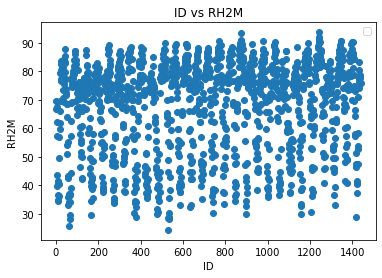

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


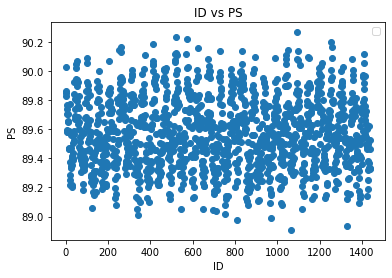

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


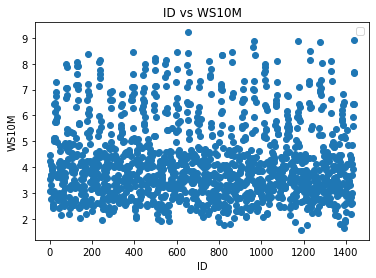

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


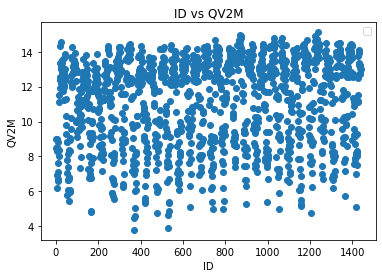

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


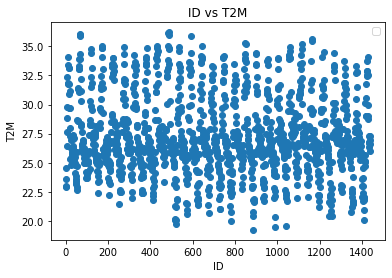

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


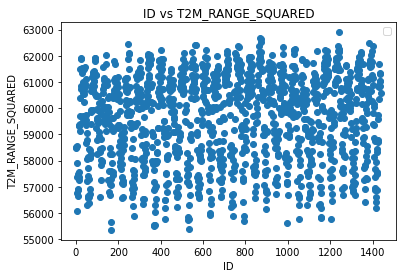

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


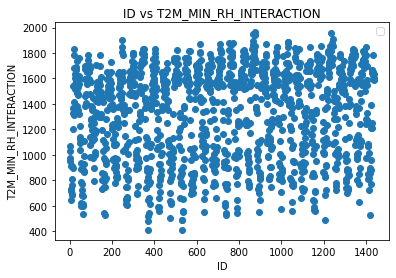

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


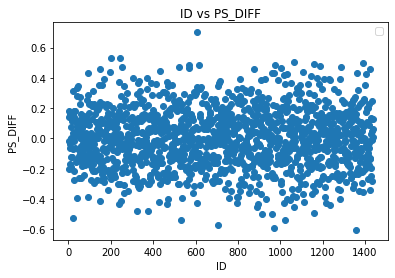

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


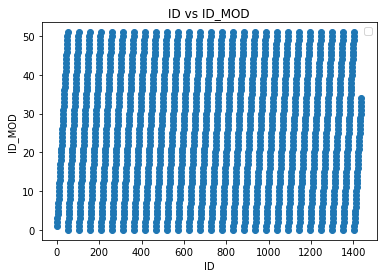

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


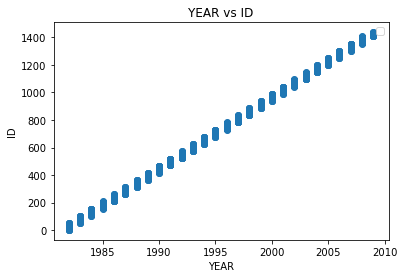

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


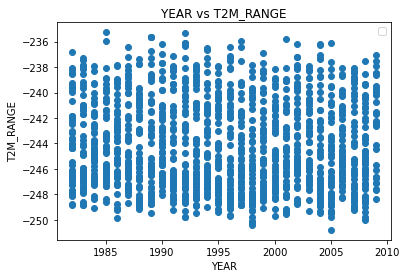

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


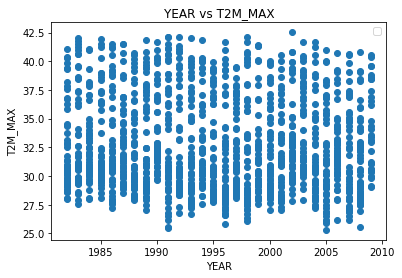

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


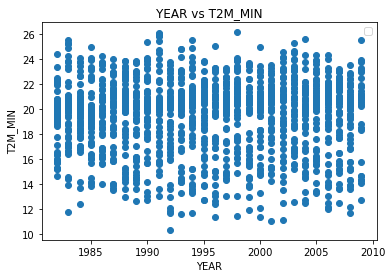

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


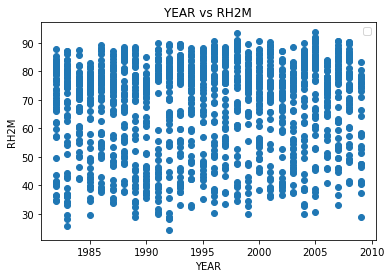

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


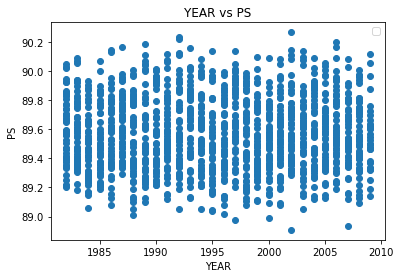

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


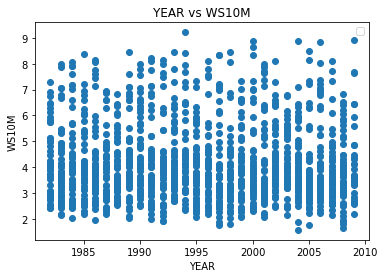

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


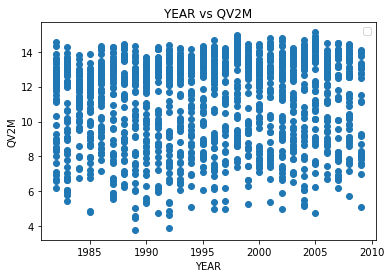

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


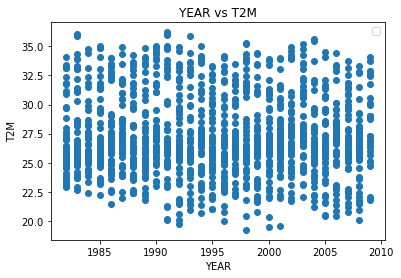

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


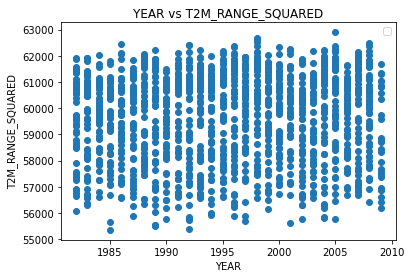

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


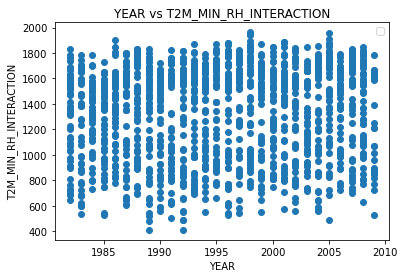

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


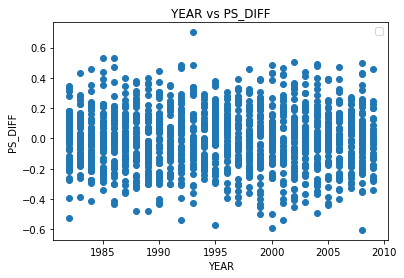

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


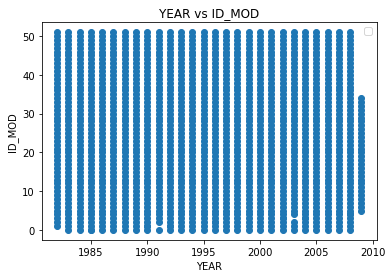

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


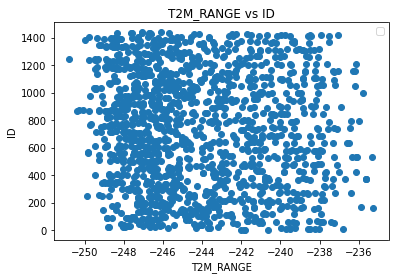

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


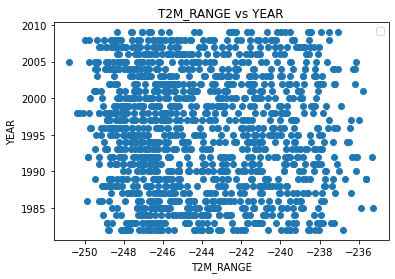

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


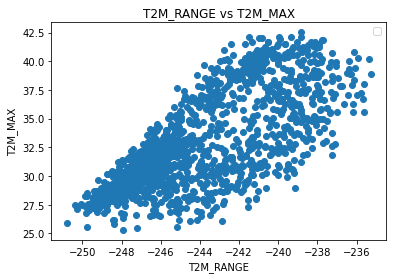

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


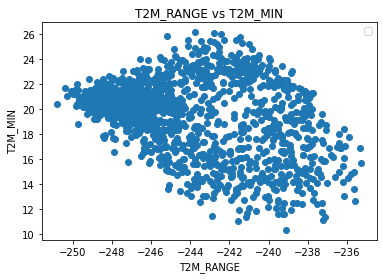

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


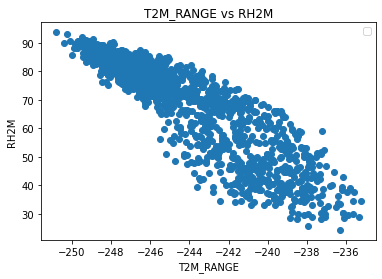

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


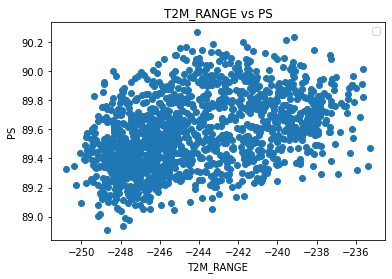

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


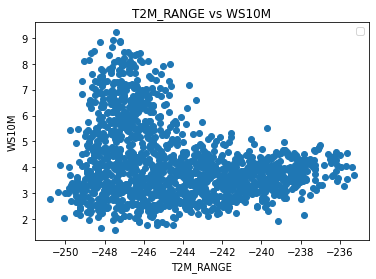

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


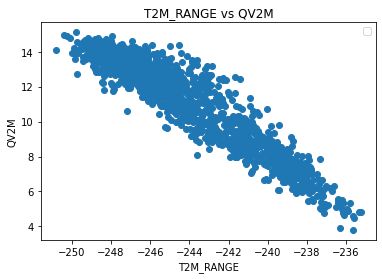

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


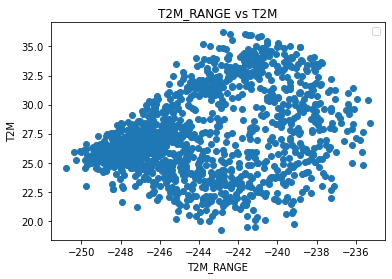

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


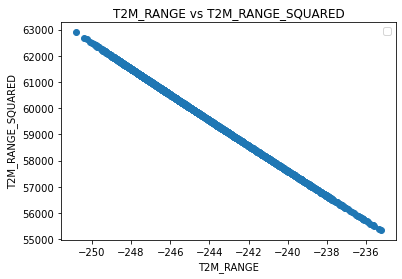

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


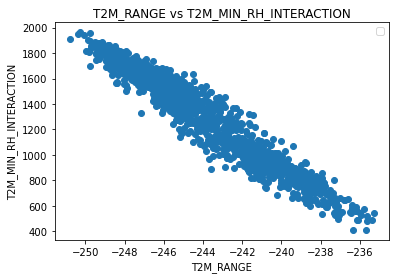

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


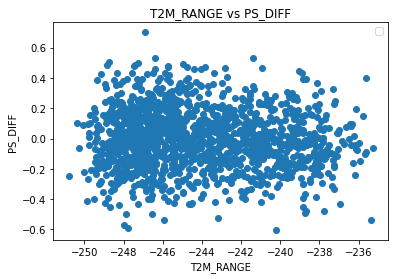

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


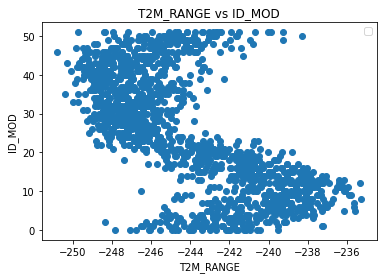

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


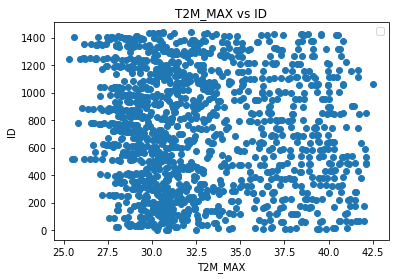

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


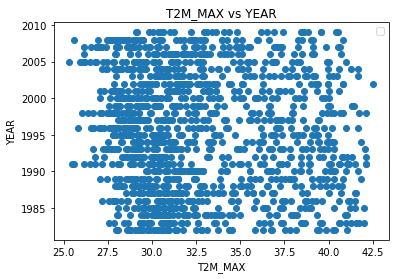

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


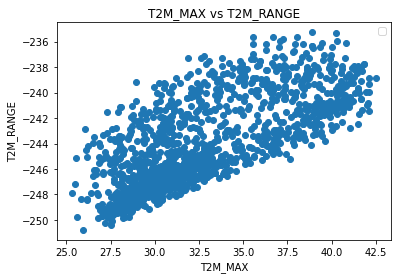

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


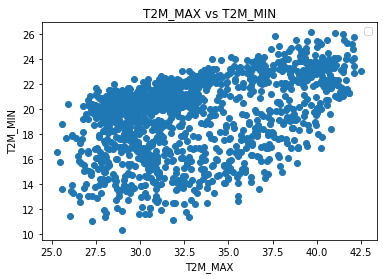

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


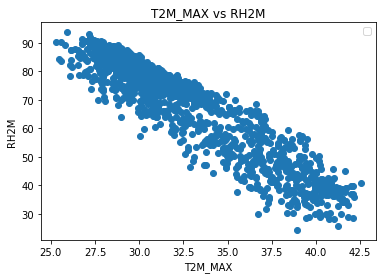

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


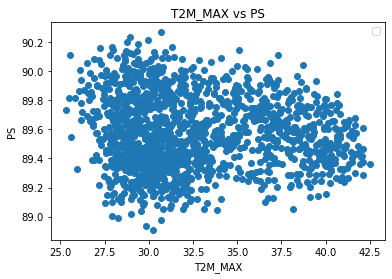

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


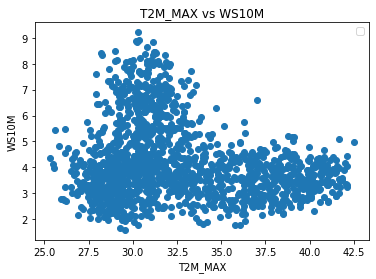

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


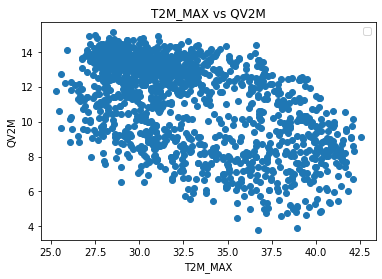

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


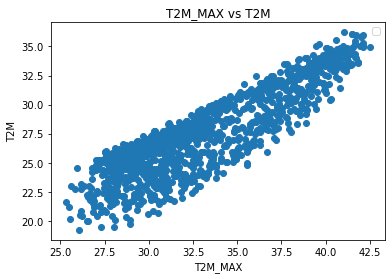

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


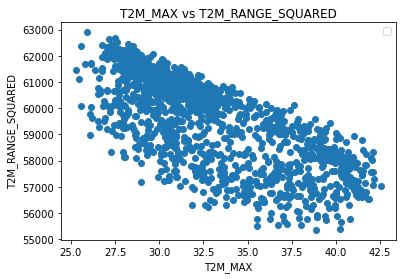

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


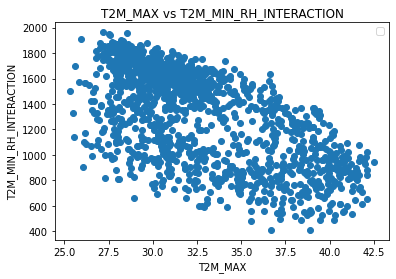

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


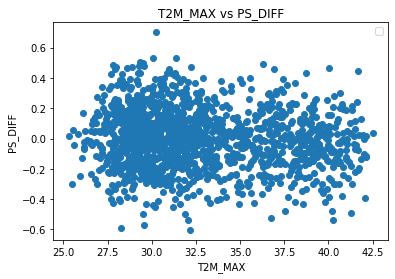

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


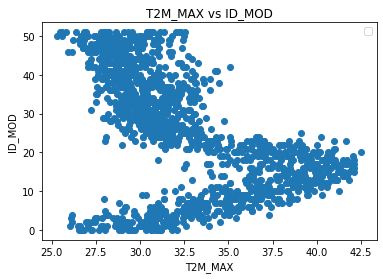

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


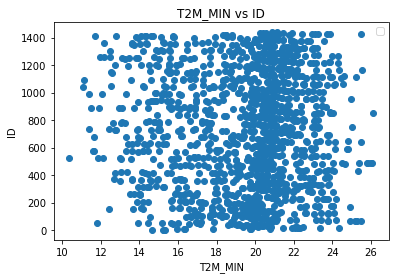

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


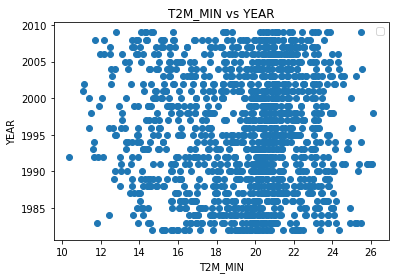

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


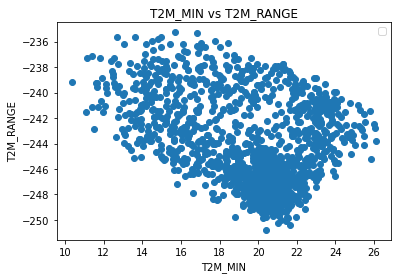

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


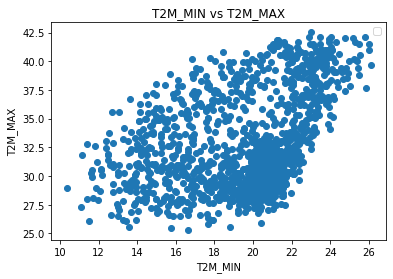

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


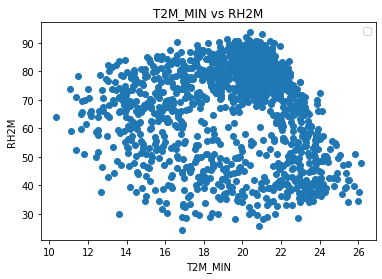

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


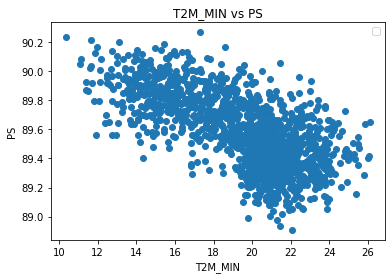

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


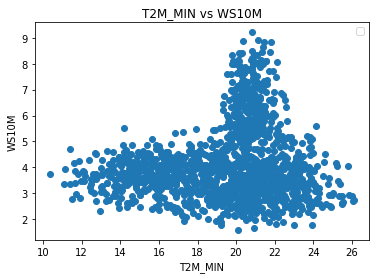

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


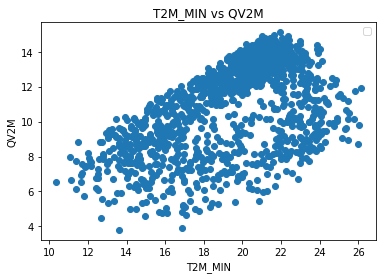

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


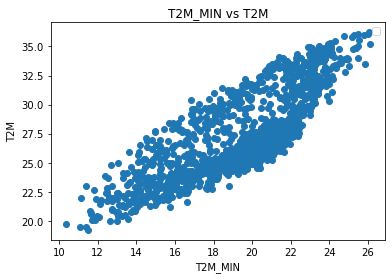

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


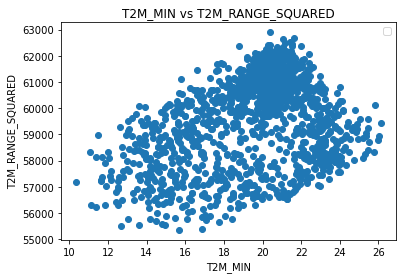

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


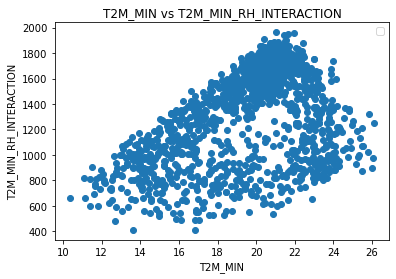

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


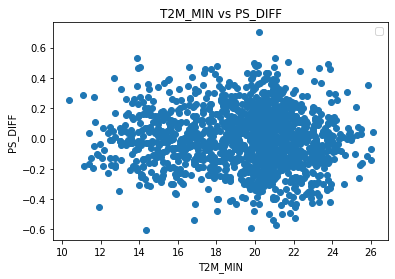

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


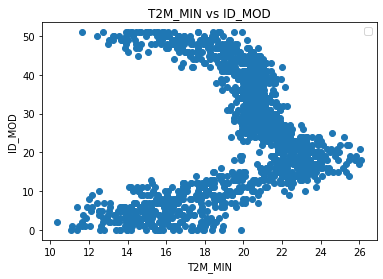

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


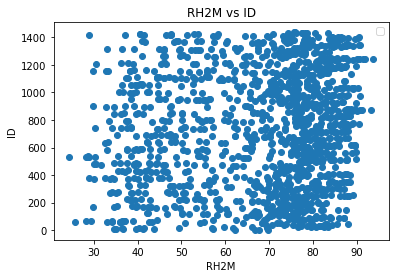

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


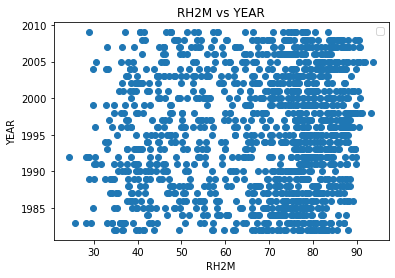

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


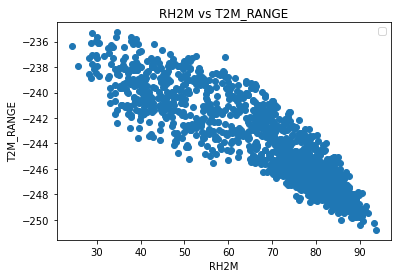

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


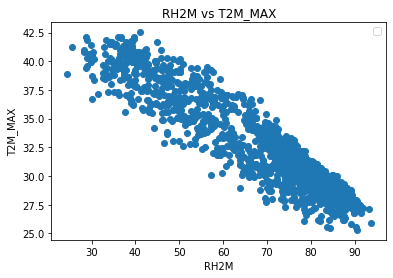

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


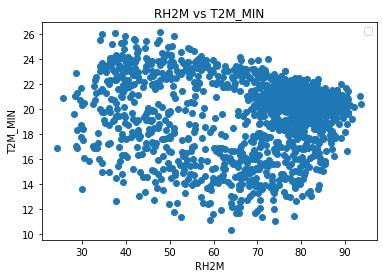

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


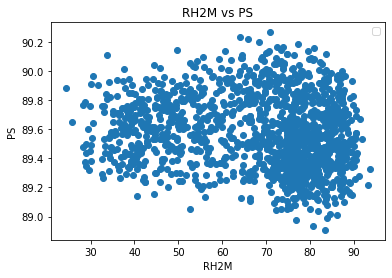

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


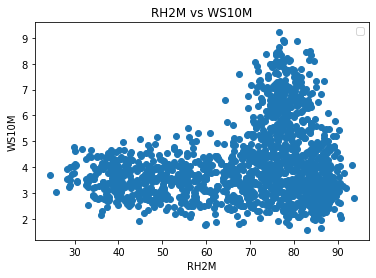

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


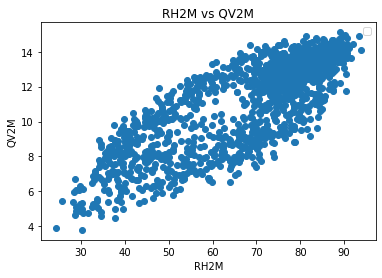

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


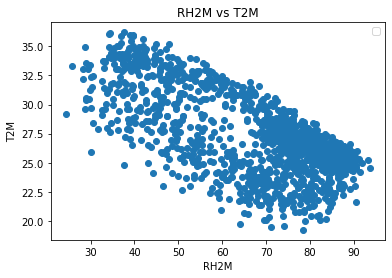

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


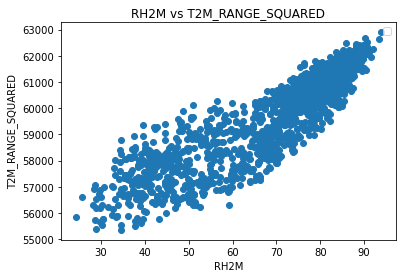

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


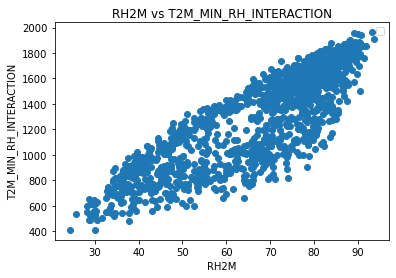

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


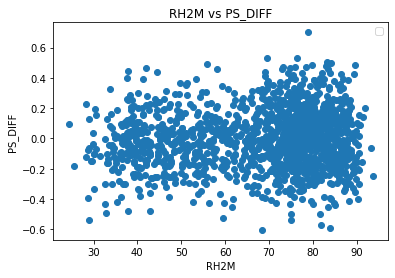

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


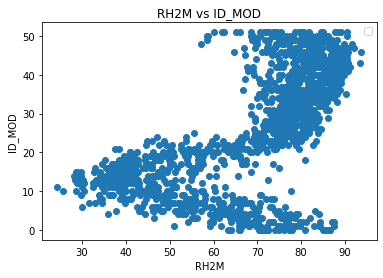

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


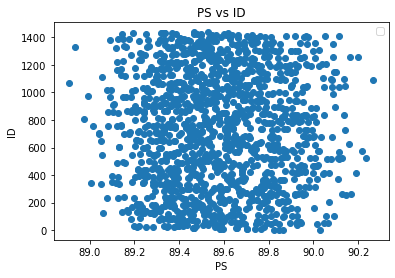

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


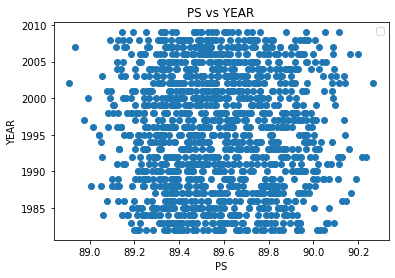

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


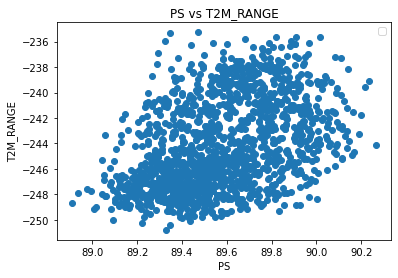

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


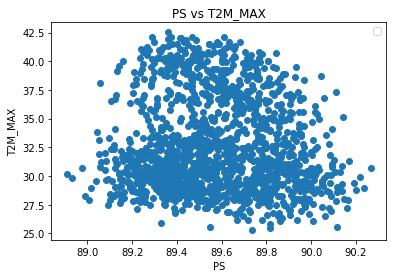

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


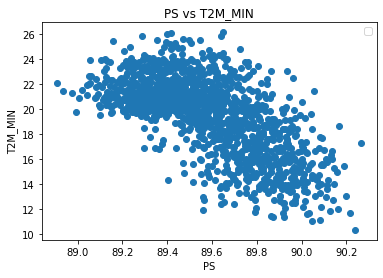

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


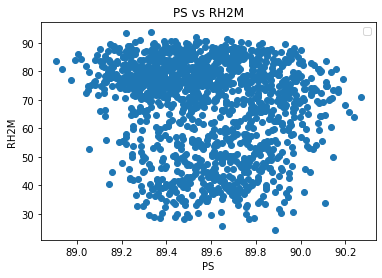

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


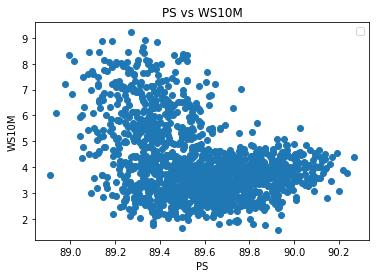

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


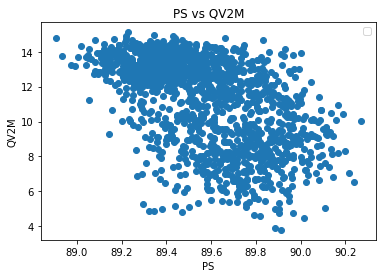

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


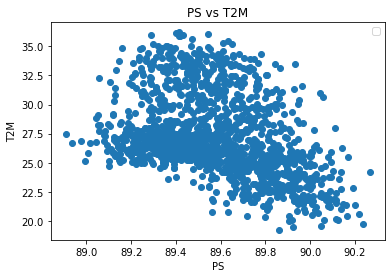

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


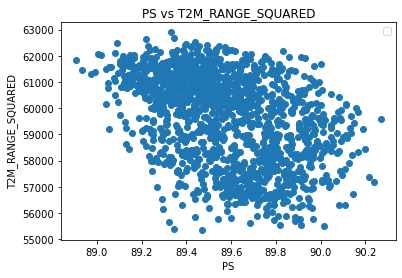

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


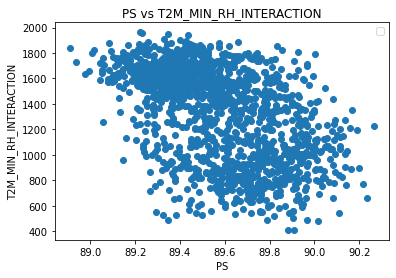

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


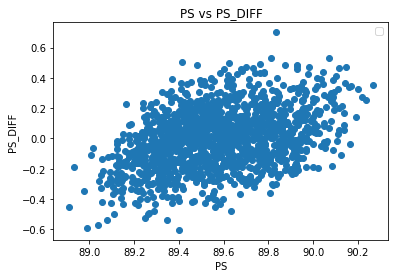

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


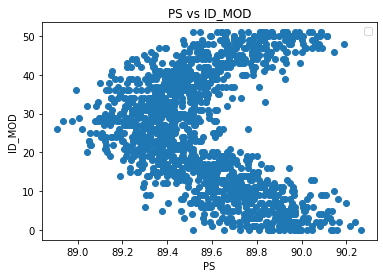

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


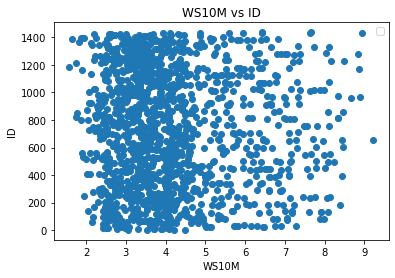

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


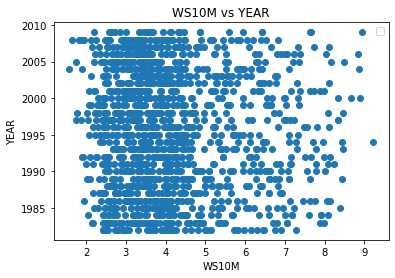

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


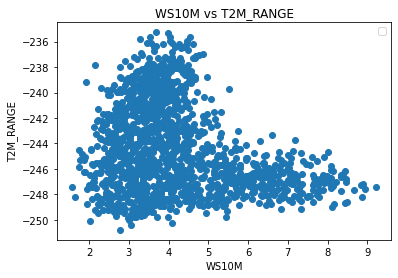

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


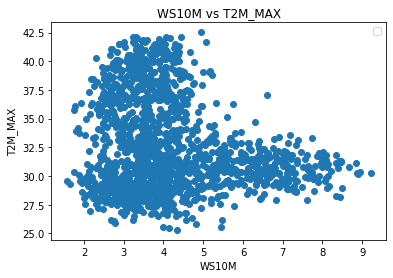

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


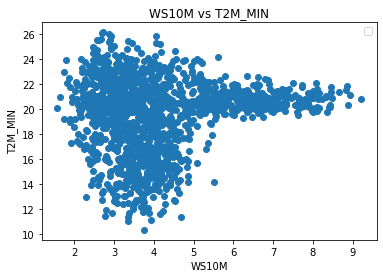

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


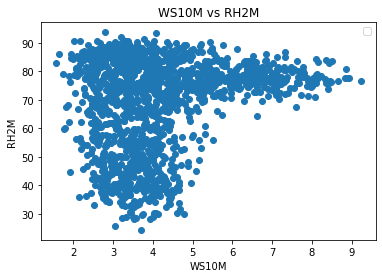

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


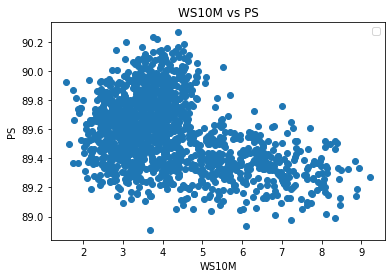

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


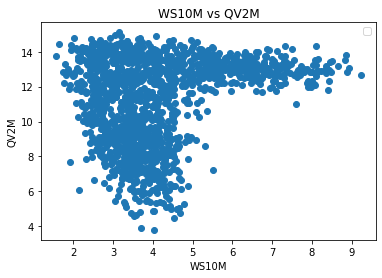

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


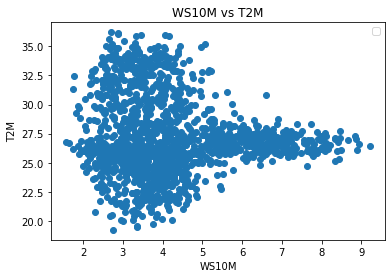

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


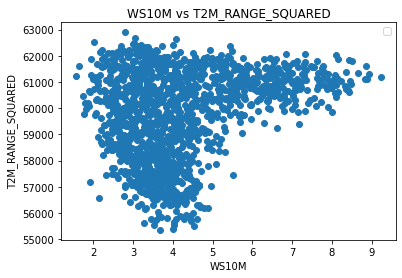

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


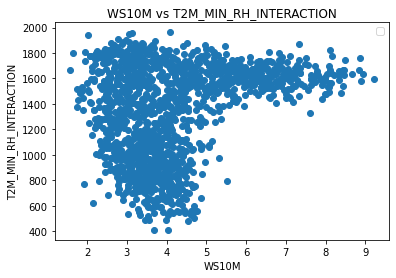

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


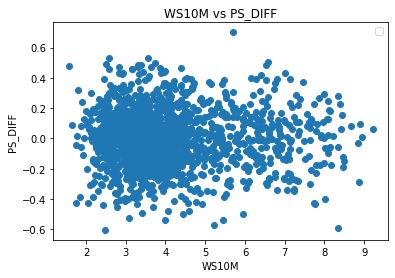

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


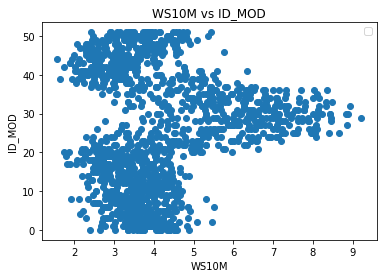

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


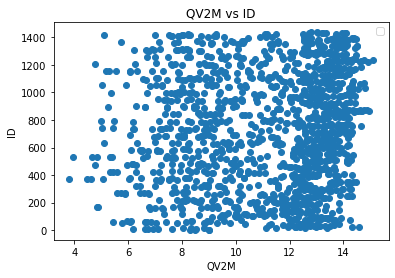

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


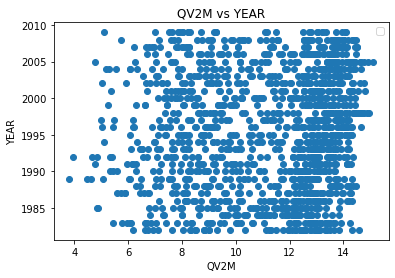

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


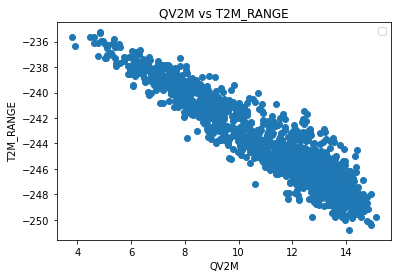

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


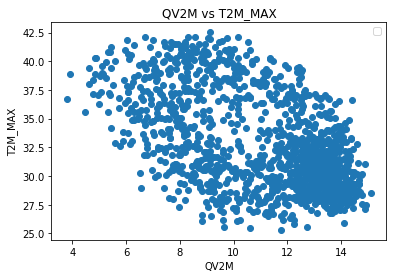

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


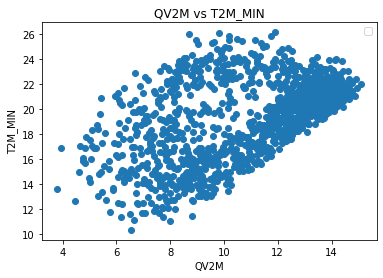

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


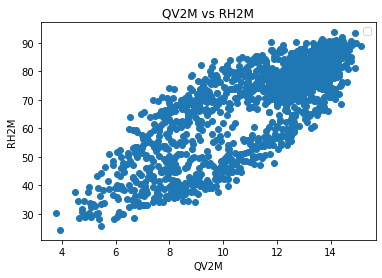

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


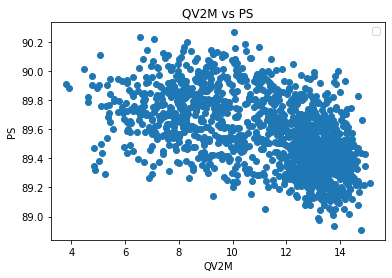

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


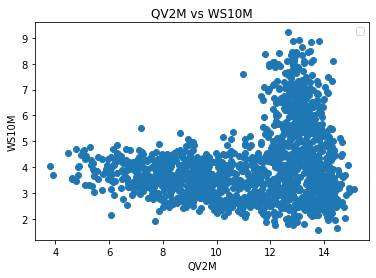

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


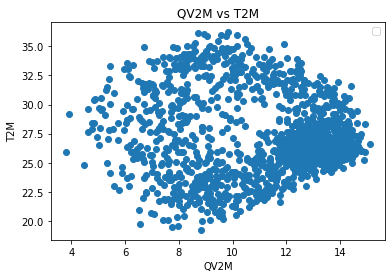

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


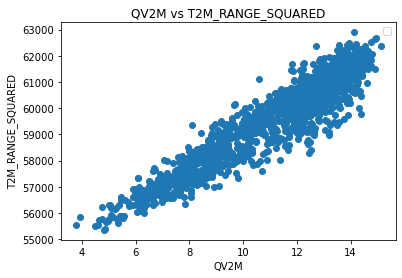

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


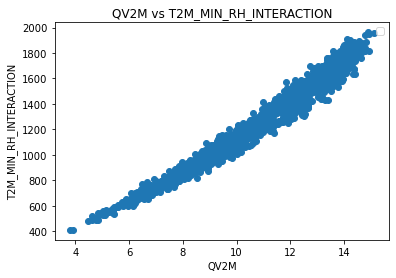

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


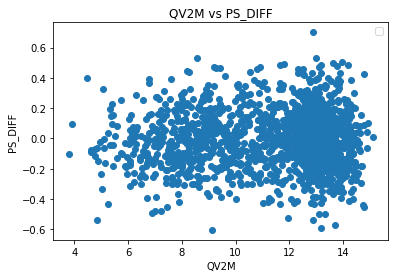

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


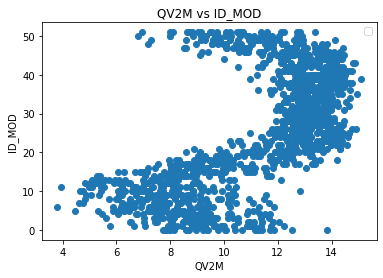

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


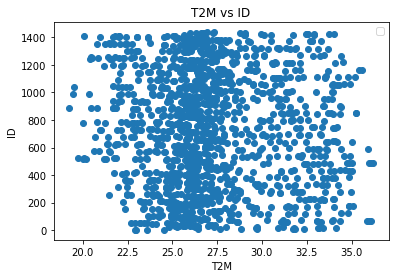

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


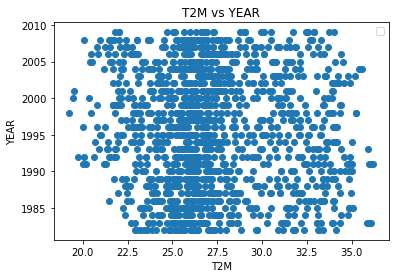

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


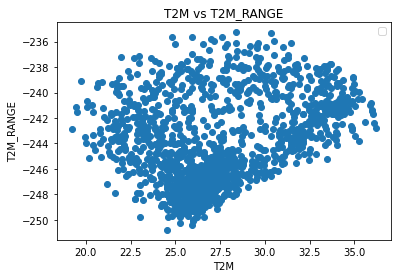

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


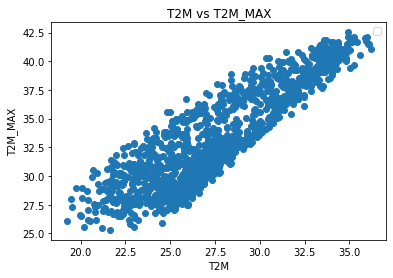

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


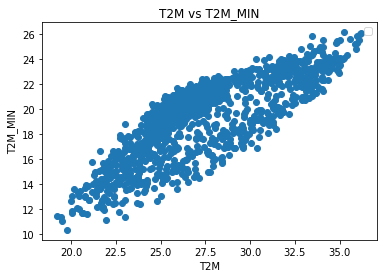

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


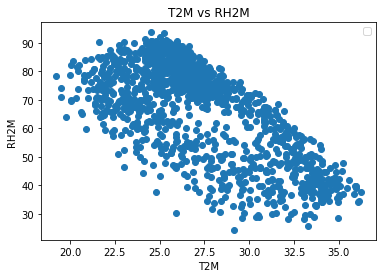

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


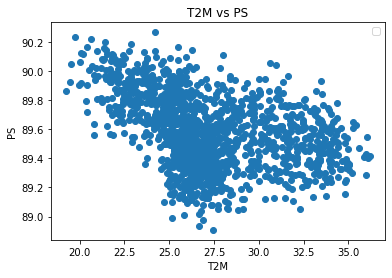

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


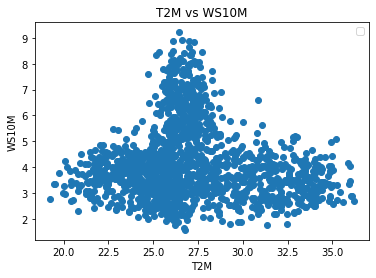

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


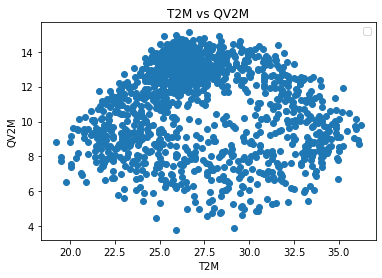

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


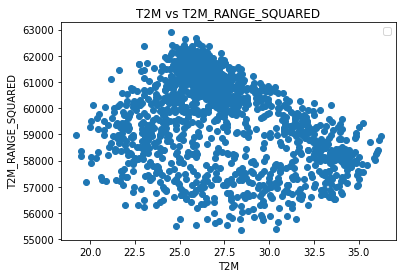

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


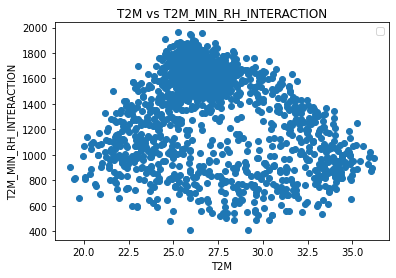

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


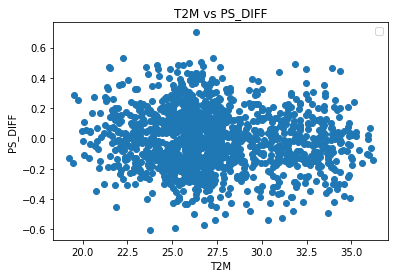

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


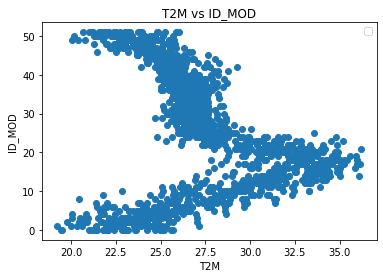

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


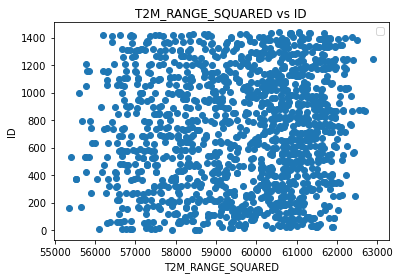

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


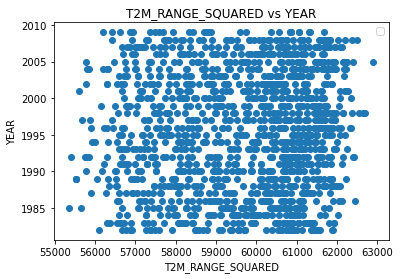

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


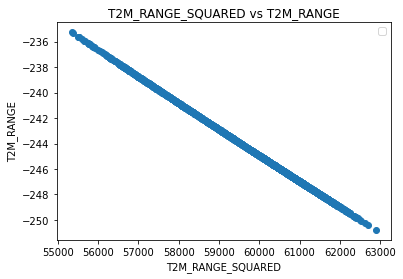

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


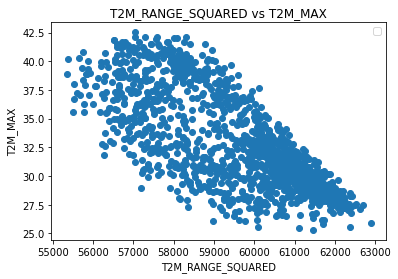

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


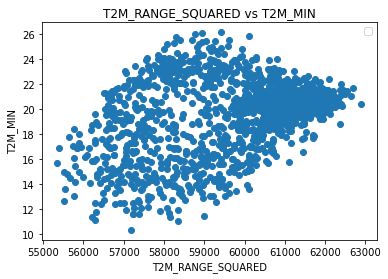

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


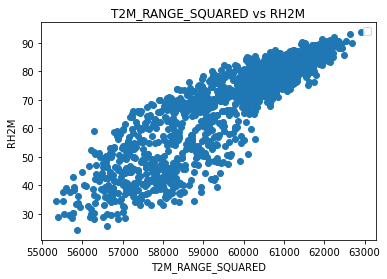

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


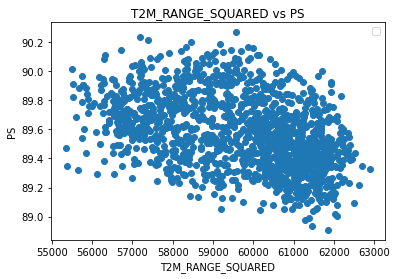

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


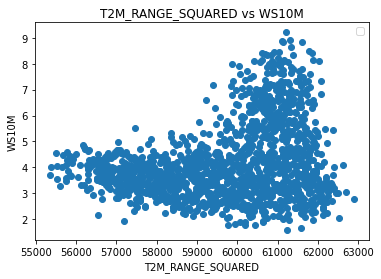

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


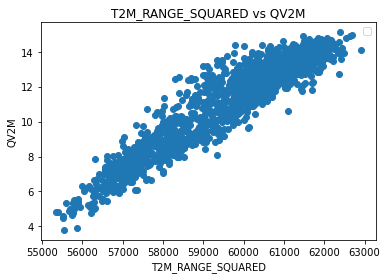

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


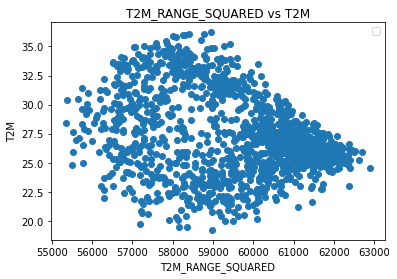

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


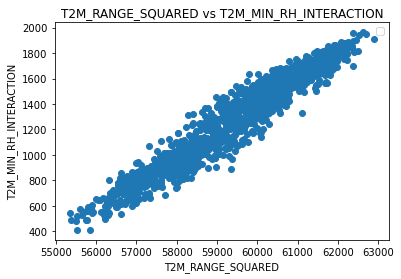

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


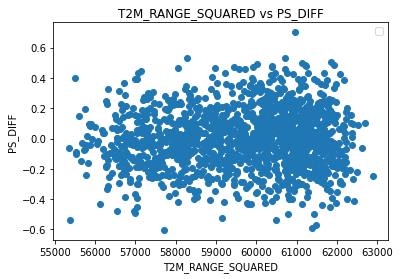

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


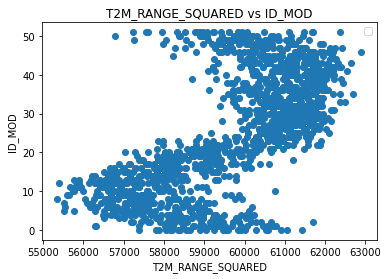

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


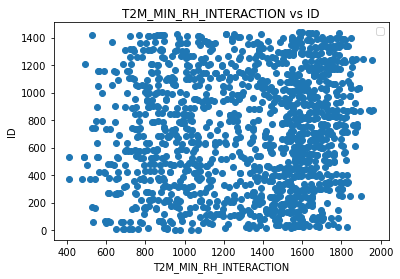

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


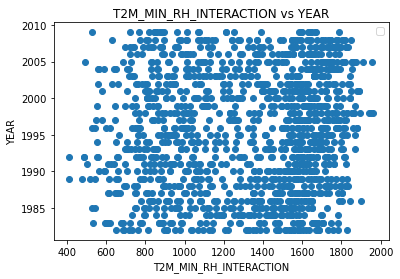

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


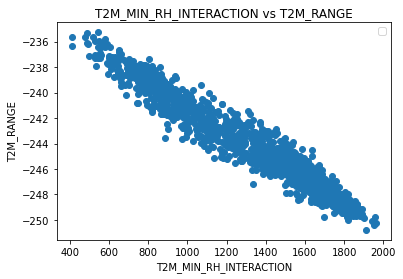

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


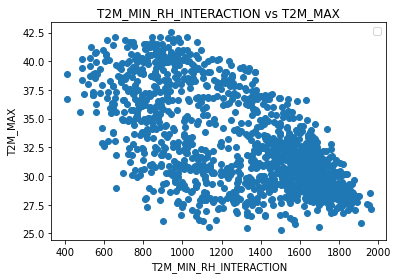

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


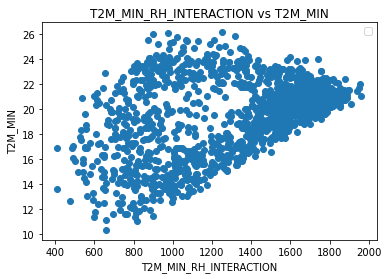

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


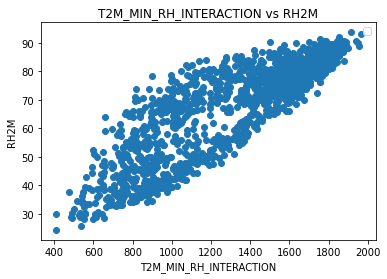

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


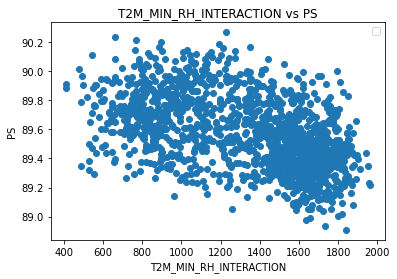

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


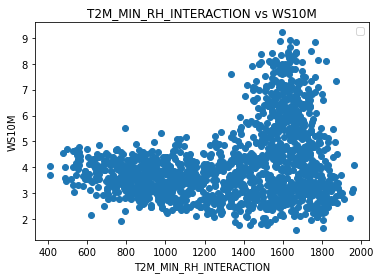

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


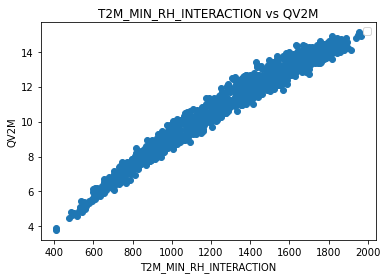

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


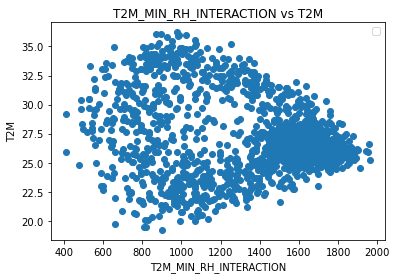

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


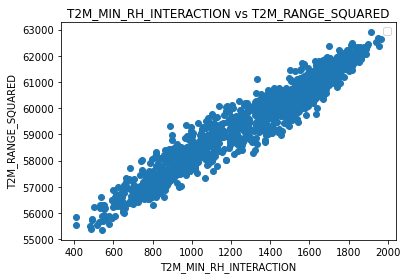

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


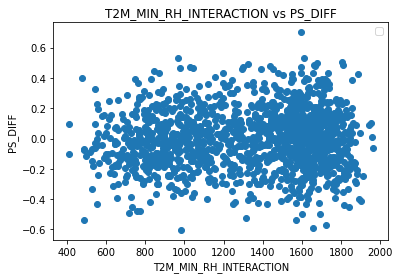

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


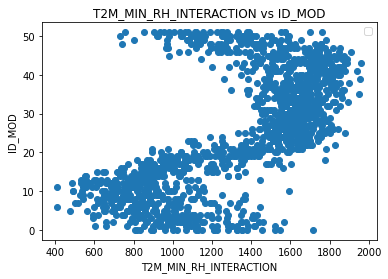

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


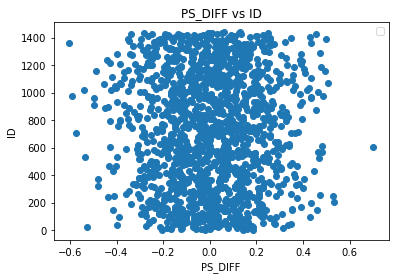

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


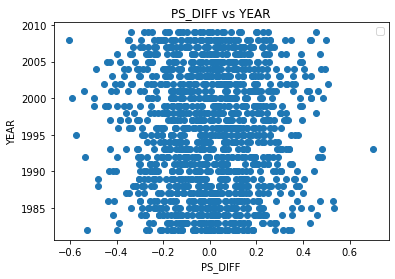

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


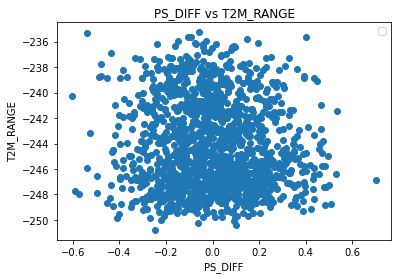

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


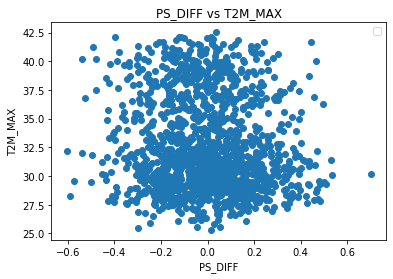

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


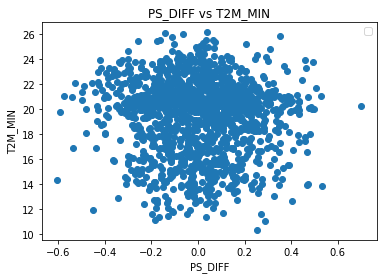

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


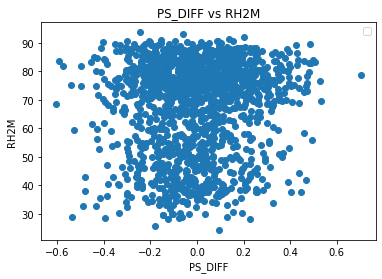

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


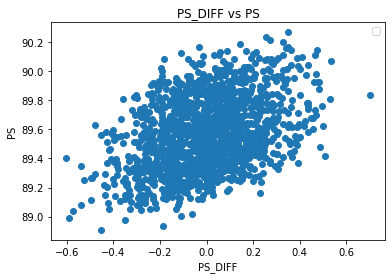

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


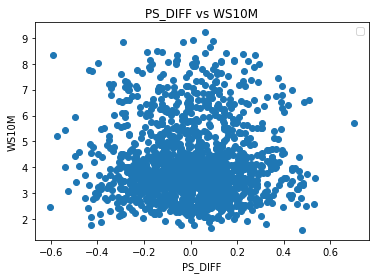

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


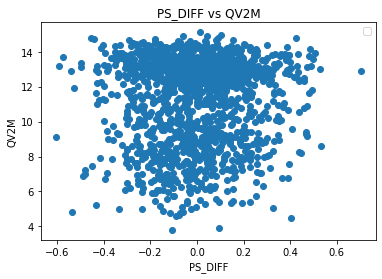

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


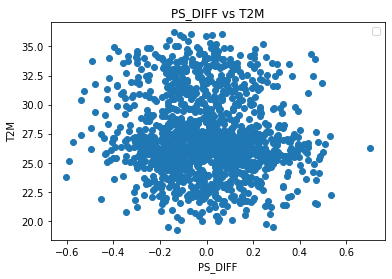

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


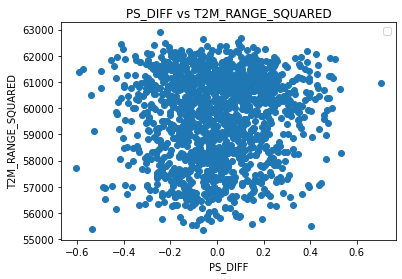

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


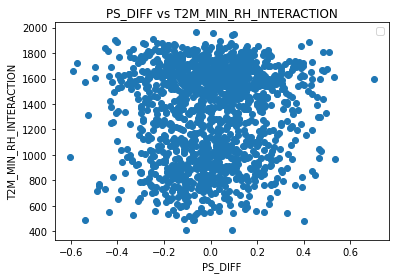

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


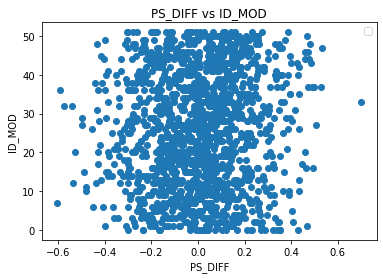

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


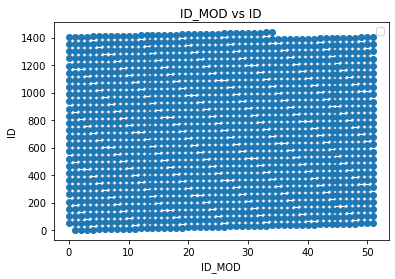

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


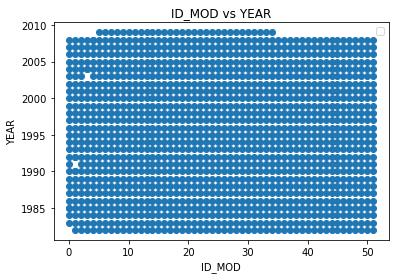

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


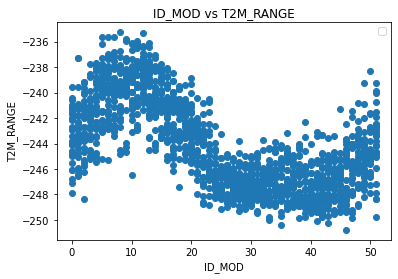

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


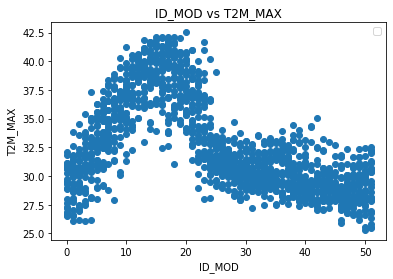

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


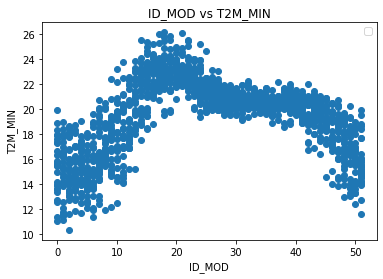

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


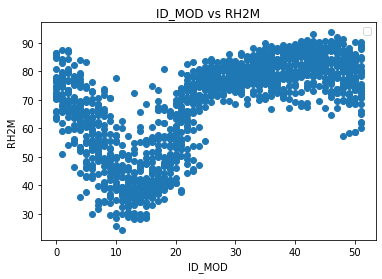

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


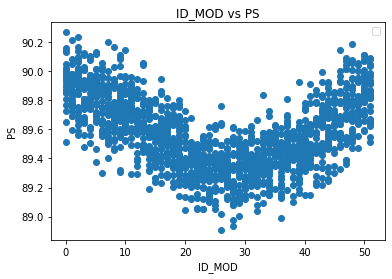

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


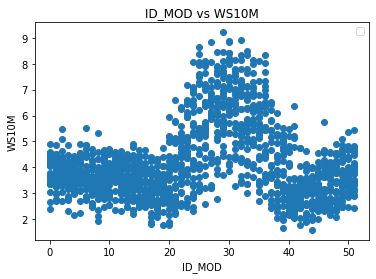

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


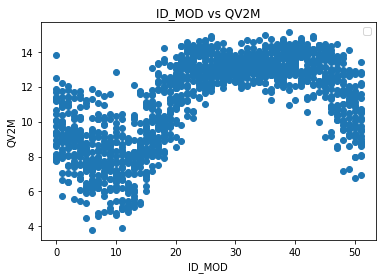

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


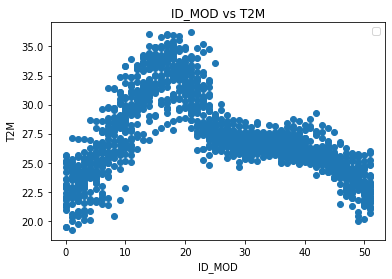

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


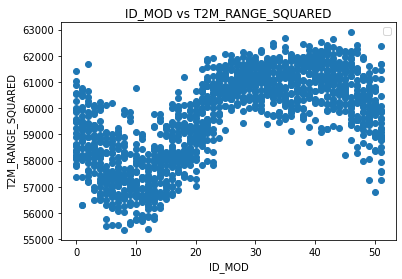

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


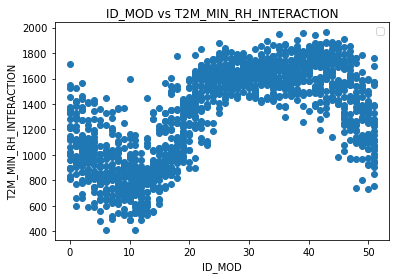

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


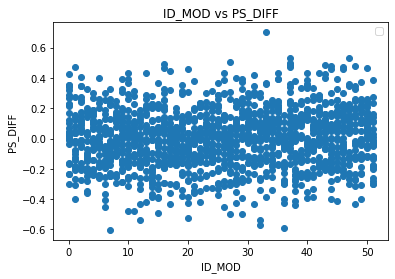

In [12]:
# @title Scatter Plots Features vs. Features
for x_col in processed_data.columns:
  for y_col in processed_data.columns:
    if x_col != y_col and x_col != 'VACATION_RATE' and y_col != 'VACATION_RATE':
      figure = plt.figure
      ax = plt.gca()
      ax.scatter(processed_data[x_col], processed_data[y_col])
      ax.set_xlabel(x_col)
      ax.set_ylabel(y_col)
      ax.set_title("{} vs {}".format(x_col, y_col))
      plt.legend()
      plt.show()

# Data Split

I have three lists with the same name 'features' because i was trying to experiment by considering different columns just to check which one would give give a more accurate prediction

In [13]:
# Selecting relevant features
features = ['ID', 'T2M_RANGE', 'T2M_MIN', 'T2M_MAX', 'RH2M', 'PS', 'WS10M', 'T2M_RANGE_SQUARED', 'T2M_MIN_RH_INTERACTION', 'PS_DIFF']

#selecting features with correlation greater than 0.4

# features = ['ID_MOD', 'T2M_RANGE', 'T2M_MIN', 'WS10M', 'T2M_RANGE_SQUARED', 'T2M_MIN_RH_INTERACTION', 'PS_DIFF']
# features = ['T2M_RANGE', 'T2M_MIN', 'RH2M', 'QV2M','ID_MOD']

X = processed_data[features]
y = processed_data['VACATION_RATE']

# This is the test file for submission
test_X = processed_test[features]

In [14]:
# @title Randomize and split data for training
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=288)

# Model Explorations

## 1. Linear Regression

In [15]:
regressor = LinearRegression()
regressor.fit(train_X, train_y)

LinearRegression()

In [16]:
# R-score for Validation (Higher the better)
regressor.score(val_X,val_y)

0.5070351451366979

In [17]:
# @title Manual Verification of Validation Set
y_pred = regressor.predict(val_X)
val_d = {'y_pred': y_pred, 'y_test': val_y}
pd.DataFrame(val_d)

y_pred     y_test
756   14.322972   4.543398
251    7.141671   0.441783
1228  16.343523  29.228602
517   12.067500  58.473691
1311  47.508279  30.291925
...         ...        ...
1427  12.605762  16.950204
1186  14.532179   8.739594
1203  34.490180   4.855108
88     8.094787   7.560516
72     5.977837  47.308487

[360 rows x 2 columns]

In [18]:
# @title RMSE LOSS COMPUTATION (Lower the better => 0)
rmse = np.sqrt(mean_squared_error(val_d['y_pred'], val_d['y_test'], squared = False))
rmse

16.638902640965235

In [19]:
# @title Generate test predictions for Submissions
y_pred_submission = regressor.predict(test_X)
test_d = {'ID': test_X['ID'], 'y_pred': y_pred_submission}
LR_test_submit = pd.DataFrame(test_d)
LR_test_submit

ID      y_pred
1    1441  636.332231
2    1442  677.358451
3    1443  653.794852
4    1444  661.555827
5    1445  633.568812
..    ...         ...
695  2135  790.162924
696  2136  652.817094
697  2137  666.307215
698  2138  600.308665
699  2139  625.702643

[699 rows x 2 columns]

In [20]:
# @title Checkpoint Submission File
LR_test_submit.to_csv('linear_regression_test_submit.csv', index=False)

## 2. Random Forest Regression

Random Forest can recognize non-linear relationships between the features (temperature, humidity, surface pressure) and the target variable (vacation rate). Linear Regression assumes a linear relationship, which may not always be the case. further, Random Forest is less sensitive to outliers in the data compared to Linear Regression. Outliers can significantly influence the parameter estimates. 

In [21]:
# Initialize and train the model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(train_X, train_y)

RandomForestRegressor(random_state=42)

In [22]:
# R-score for Validation (Higher the better)
regressor.score(val_X,val_y)

0.9410835159103648

In [23]:
# @title Manual Verification of Validation Set
y_pred = regressor.predict(val_X)
val_d = {'y_pred': y_pred, 'y_test': val_y}
pd.DataFrame(val_d)

y_pred     y_test
756    5.845024   4.543398
251    1.820460   0.441783
1228  23.859312  29.228602
517   54.271721  58.473691
1311  16.607815  30.291925
...         ...        ...
1427  25.233826  16.950204
1186  10.645372   8.739594
1203   3.740987   4.855108
88    10.917543   7.560516
72    35.141314  47.308487

[360 rows x 2 columns]

In [25]:
# @title RMSE LOSS COMPUTATION (Lower the better => 0)

rmse = np.sqrt(mean_squared_error(val_d['y_pred'], val_d['y_test'], squared = False))
rmse


2.39837758277945

In [ ]:
# @title RMSE LOSS COMPUTATION (Lower the better => 0)
rmse =np.sqrt(mean_squared_error(val_df['y_test'], val_df['y_pred'], squared=False))
rmse

In [ ]:
# @title Generate test predictions for Submissions
y_pred_submission = regressor.predict(test_X)

In [ ]:
#Create a DataFrame for test set predictions
test_d = {'ID': test_X['ID'], 'y_pred': y_pred_submission}
DT_test_submit = pd.DataFrame(test_d)

In [ ]:
#Using .clip() to ensure that the predicted values lie within the range of 1 to 100
DT_test_submit['y_pred'].clip(upper=100, inplace=True)
DT_test_submit['y_pred'].clip(lower=0, inplace=True)

In [ ]:
# @title Checkpoint Submission File
DT_test_submit.to_csv('DT_test_submit.csv', index=False)

# Using Hyperparameters

Came across the concpet of hyperparameters while looking for ways to improve my mode. Hyperparameters enable us to better the working of the model and control various aspects like learning rate, etc 

In [ ]:


# Splitting the training data into training and validation sets
# train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# regressor = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(train_X, train_y)

# Best hyperparameters
# best_regressor = grid_search.best_estimator_
# print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model on the validation set
# score = best_regressor.score(val_X, val_y)
# print("Validation set score:", score)

# # Make predictions on the validation set
# y_pred = best_regressor.predict(val_X)

# Calculate rmse
# rmse = mean_squared_error(val_y, y_pred, squared=False)
# print("Root Mean Squared Error (RMSE):", rmse)

# Feature Importance
# feature_importances = best_regressor.feature_importances_
# sorted_indices = feature_importances.argsort()

# plt.figure(figsize=(10, 6))
# plt.barh(range(train_X.shape[1]), feature_importances[sorted_indices])
# plt.yticks(range(train_X.shape[1]), train_X.columns[sorted_indices])
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance for Random Forest Model')
# plt.show()

# Make predictions on the test set
# y_pred_submission = best_regressor.predict(test_X)

# Create a DataFrame for test set predictions
# test_df = pd.DataFrame({'ID': test_X['ID'], 'y_pred': y_pred_submission})

# Apply decision-making to the predictions (clip values between 0 and 100)
# test_df['y_pred'] = test_df['y_pred'].clip(lower=0, upper=50)

# @title Checkpoint Submission Filee
# test_df.to_csv('improved.csv', index=False)


# 5.  Gradient Boosting Algorithm

The reason behind dropping the previous algorithms and using the Gradient Boosting Algorithm to solve the given problem is because this algorithm combines all the predictions of multiple weak learners to create a better predictive model. Hence, the accuracy increases.

In [ ]:
# Calculate the IQR for the target variable (train_y)
#IQR stands for interquartile rangee
Q1 = train_y.quantile(0.25)
Q3 = train_y.quantile(0.75)
IQR = Q3 - Q1
IQR

Here, the outliers are being removed so that the noise is minimized

In [ ]:
# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Remove outliers from the training data
train_X_filtered = train_X[(train_y >= lower_bound) & (train_y <= upper_bound)]
train_y_filtered = train_y[(train_y >= lower_bound) & (train_y <= upper_bound)]

In [ ]:
# Create a Gradient Boosting Regressor
regressor = GradientBoostingRegressor(random_state=101)

In [ ]:
# Fit the model to the filtered training data
regressor.fit(train_X_filtered, train_y_filtered)

In [ ]:
# Evaluate the model on the validation data
score = regressor.score(val_X, val_y)
score

In [ ]:
# Initialize separate random forest regressor models for temperature and pressure
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
pressure_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the temperature model
temp_model.fit(X_train, y_train['T2M'])

In [ ]:
# Make predictions on the validation data
y_pred = regressor.predict(val_X)

In [ ]:
rmse = np.sqrt(mean_squared_error(val_y, y_pred, squared=False))
rmse

In [ ]:
# Make predictions on the test data
y_pred_submission = regressor.predict(test_X)
y_pred_submission

In [ ]:

# Create a DataFrame for the test predictions
test_d = {'ID': test_X['ID'], 'y_pred': y_pred_submission}
GBR_test_submit = pd.DataFrame(test_d)

# using .clip() to ensure that the predictions lie between 0 and 100
GBR_test_submit['y_pred'].clip(upper=100, inplace=True)
GBR_test_submit['y_pred'].clip(lower=0, inplace=True)
GBR_test_submit 

In [ ]:
# Clip predictions to be between 0 and 100
# GBR_test_submit['y_pred'].clip(upper=100, inplace=True)
# GBR_test_submit['y_pred'].clip(lower=0, inplace=True)
# GBR_test_submit['y_pred']

In [ ]:
# Save the submission file
GBR_test_submit.to_csv('/enter/path/to/training/file/*.csv', index=False)

# RandomForestRegressor, MultiOutputRegressor

Understood the problem better after making the submissions and analysing the rmse score. In this case we are dropping some specific columns from the training set as they are the target variables. Since T2M and QV2M are also given to be target varibales, we predict their values based on the other independent features first, combine them with the other features and then use all these combined features to predict our ultimate target varibale, i.e. vacation_rate. 

MultiOutputRegressor: This strategy consists of fitting one regressor per target. This is a simple strategy for extending regressors that do not natively support multi-target regression.By using MultiOutputRegressor, we can ensure that the predictions for all three target variables are made together within the same model. This can help maintain consistency in the predictions because the model considers the relationships between the target variables simultaneously.  It also simplifies the workflow by allowing us to train a single model that handles all target variables. In this problem, the prediction of vacation_rate is influenced by the predictions of 'T2M' and 'QV2M.' A multi-output model can capture such dependencies effectively.

In [ ]:
# Splitting features and target variables
features = data.drop(['T2M', 'QV2M', 'VACATION_RATE'], axis=1)
target = data[['T2M', 'QV2M', 'VACATION_RATE']]

In [ ]:
# Splitting into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# Initialize separate random forest regressor models for temperature and pressure
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
pressure_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the temperature model
temp_model.fit(X_train, y_train['T2M'])

In [ ]:
# Train the pressure model
pressure_model.fit(X_train, y_train['QV2M'])

In [ ]:
# Predict temperature and pressure on the validation set
temp_preds = temp_model.predict(X_valid)
pressure_preds = pressure_model.predict(X_valid)

In [ ]:
# Initialize a random forest regressor model for vacation rate
vacation_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Combine the predicted temperature and pressure with the original features
X_valid_combined = X_valid.copy()
X_valid_combined['T2M'] = temp_preds
X_valid_combined['QV2M'] = pressure_preds

In [ ]:
# Train the vacation rate model using the combined features
vacation_model.fit(X_valid_combined, y_valid['VACATION_RATE'])

In [ ]:
# Predict vacation rate on the validation set
vacation_preds = vacation_model.predict(X_valid_combined)

In [ ]:
# Calculate RMSE for each target variable
rmse_t2m = np.sqrt(mean_squared_error(y_valid['T2M'], temp_preds, squared=False))
rmse_qv2m = np.sqrt(mean_squared_error(y_valid['QV2M'], pressure_preds, squared=False))
rmse_vacation_rate = np.sqrt(mean_squared_error(y_valid['VACATION_RATE'], vacation_preds, squared=False))

In [ ]:
# Load the test data
test_data = pd.read_csv('test.csv')

In [ ]:
# Predict temperature and pressure for the test data
test_temp_preds = temp_model.predict(test_data)
test_pressure_preds = pressure_model.predict(test_data)

In [ ]:
# Combine the predicted temperature and pressure with the original features for the test data
test_data_combined = test_data.copy()
test_data_combined['T2M'] = test_temp_preds
test_data_combined['QV2M'] = test_pressure_preds

In [ ]:
# Predict vacation rate for the test data
test_vacation_preds = vacation_model.predict(test_data_combined)

In [ ]:
# Prepare submission file
rfr = pd.DataFrame({
    'ID': test_data['ID'],
    'VACATION_RATE': test_vacation_preds
})

In [ ]:
# Save submission file
rfr.to_csv('rfr.csv', index=False)

# Trying another approach to explore different ways to solve the problem 

In [ ]:
# Load the training data
train_data = pd.read_csv('train.csv')

In [ ]:
# Splitting features and target variables
features = ['ID_MOD', 'T2M_RANGE', 'T2M_MIN', 'WS10M', 'T2M_RANGE_SQUARED', 'T2M_MIN_RH_INTERACTION', 'PS_DIFF']
target = train_data[['T2M', 'QV2M', 'VACATION_RATE']]

In [ ]:
# Splitting into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# Calculate the IQR for the target variable (train_y)
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Remove outliers from the training data
# I removed the outliers like this:
X_train_filtered = X_train[(train_y >= lower_bound) & (y_train <= upper_bound)]
y_train_filtered = y_train[(train_y >= lower_bound) & (y_train <= upper_bound)]

In [ ]:
# Initialize separate random forest regressor models for temperature and pressure
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
pressure_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the temperature model
temp_model.fit(X_train_filtered, y_train_filtered['T2M'])

In [ ]:
# Train the pressure model
pressure_model.fit(X_train_filtered, y_train_filtered['QV2M'])

In [ ]:
# Predict temperature and pressure on the validation set
temp_preds = temp_model.predict(X_valid)
pressure_preds = pressure_model.predict(X_valid)

In [ ]:
# Initialize a random forest regressor model for vacation rate
vacation_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Combine the predicted temperature and pressure with the original features
X_valid_combined = X_valid.copy()
X_valid_combined['T2M'] = temp_preds
X_valid_combined['QV2M'] = pressure_preds

In [ ]:
# Train the vacation rate model using the combined features
vacation_model.fit(X_valid_combined, y_valid['VACATION_RATE'])

In [ ]:
# Predict vacation rate on the validation set
vacation_preds = vacation_model.predict(X_valid_combined)

In [ ]:
# Calculate RMSE for each target variable
rmse_t2m = np.sqrt(mean_squared_error(y_valid['T2M'], temp_preds, squared=False))
rmse_qv2m = np.sqrt(mean_squared_error(y_valid['QV2M'], pressure_preds, squared=False))
rmse_vacation_rate = np.sqrt(mean_squared_error(y_valid['VACATION_RATE'], vacation_preds, squared=False))
 

In [ ]:
# Load the test data
test_data = pd.read_csv('test.csv')

In [ ]:
# Predict temperature and pressure for the test data
test_temp_preds = temp_model.predict(test_data)
test_pressure_preds = pressure_model.predict(test_data)

In [ ]:
# Combine the predicted temperature and pressure with the original features for the test data
test_data_combined = test_data.copy()
test_data_combined['T2M'] = test_temp_preds
test_data_combined['QV2M'] = test_pressure_preds

In [ ]:
# Predict vacation rate for the test data
test_vacation_preds = vacation_model.predict(test_data_combined)

In [ ]:
# Prepare submission file
sub = pd.DataFrame({
    'ID': test_data['ID'],
    'VACATION_RATE': test_vacation_preds
})

# Save submission file
sub.to_csv('finalcode.csv', index=False)

Here i thought of considering only those features that have a higher correlation greater than 0.4 

In [ ]:
# Load the training data
train_data = pd.read_csv('train.csv')

# Splitting features and target variables
features = ['ID_MOD', 'T2M_RANGE', 'T2M_MIN', 'RH2M', 'QV2M']
target = train_data[['T2M', 'QV2M', 'VACATION_RATE']]

# Splitting into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)

# Calculate the IQR for the target variable (y_train)
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the training data
X_train_filtered = X_train[(y_train >= lower_bound) & (y_train <= upper_bound)]
y_train_filtered = y_train[(y_train >= lower_bound) & (y_train <= upper_bound)]

# Initialize separate random forest regressor models for temperature and pressure
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
pressure_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the temperature model
temp_model.fit(X_train_filtered, y_train_filtered['T2M'])

# Train the pressure model
pressure_model.fit(X_train_filtered, y_train_filtered['QV2M'])

# Predict temperature and pressure on the validation set
temp_preds = temp_model.predict(X_valid)
pressure_preds = pressure_model.predict(X_valid)

# Initialize a random forest regressor model for vacation rate
vacation_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Combine the predicted temperature and pressure with the original features
X_valid_combined = X_valid.copy()
X_valid_combined['T2M'] = temp_preds
X_valid_combined['QV2M'] = pressure_preds

# Train the vacation rate model using the combined features
vacation_model.fit(X_valid_combined, y_valid['VACATION_RATE'])

# Predict vacation rate on the validation set
vacation_preds = vacation_model.predict(X_valid_combined)

# Calculate RMSE for each target variable
rmse_t2m = np.sqrt(mean_squared_error(y_valid['T2M'], temp_preds))
rmse_qv2m = np.sqrt(mean_squared_error(y_valid['QV2M'], pressure_preds))
rmse_vacation_rate = np.sqrt(mean_squared_error(y_valid['VACATION_RATE'], vacation_preds))

# Load the test data
test_data = pd.read_csv('test.csv')

# Predict temperature and pressure for the test data
test_temp_preds = temp_model.predict(test_data)
test_pressure_preds = pressure_model.predict(test_data)

# Combine the predicted temperature and pressure with the original features for the test data
test_data_combined = test_data.copy()
test_data_combined['T2M'] = test_temp_preds
test_data_combined['QV2M'] = test_pressure_preds

# Predict vacation rate for the test data
test_vacation_preds = vacation_model.predict(test_data_combined)

# Prepare submission file
submit = pd.DataFrame({
    'ID': test_data['ID'],
    'VACATION_RATE': test_vacation_preds
})

# Save submission file
submit.to_csv('finalcode.csv', index=False)


# Exploring new algorithms/ways just for fun - xgboost

In [ ]:
# Splitting features and target variables
features = data.drop(['T2M', 'QV2M', 'VACATION_RATE'], axis=1)
target = data[['T2M', 'QV2M', 'VACATION_RATE']]

In [ ]:
# Splitting into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
# Initialize separate random forest regressor models for temperature and pressure
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
pressure_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the temperature model
temp_model.fit(X_train, y_train['T2M'])


In [ ]:
# Train the pressure model
pressure_model.fit(X_train, y_train['QV2M'])

In [ ]:
# Predict temperature and pressure on the validation set
temp_preds = temp_model.predict(X_valid)
pressure_preds = pressure_model.predict(X_valid)


In [ ]:
# Initialize a random forest regressor model for vacation rate
vacation_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [ ]:
# Combine the predicted temperature and pressure with the original features
X_valid_combined = X_valid.copy()
X_valid_combined['T2M'] = temp_preds
X_valid_combined['QV2M'] = pressure_preds


In [ ]:
# Train the vacation rate model using the combined features
vacation_model.fit(X_valid_combined, y_valid['VACATION_RATE'])

In [ ]:
# Predict vacation rate on the validation set
vacation_preds = vacation_model.predict(X_valid_combined)

In [ ]:
# Calculate RMSE for each target variable
rmse_t2m = np.sqrt(mean_squared_error(y_valid['T2M'], temp_preds, squared=False))
rmse_qv2m = np.sqrt(mean_squared_error(y_valid['QV2M'], pressure_preds, squared=False))
rmse_vacation_rate =np.sqrt(mean_squared_error(y_valid['VACATION_RATE'], vacation_preds, squared=False))
print(f'RMSE for T2M: {rmse_t2m}')
print(f'RMSE for QV2M: {rmse_qv2m}')
print(f'RMSE for VACATION_RATE: {rmse_vacation_rate}')

In [ ]:
# Load the test data
test_data = pd.read_csv('test.csv')

In [ ]:
# Predict temperature and pressure for the test data
test_temp_preds = temp_model.predict(test_data)
test_pressure_preds = pressure_model.predict(test_data)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the training data
train_data = pd.read_csv('train.csv')

# Calculate the IQR for the target variable (VACATION_RATE)
Q1 = train_data['VACATION_RATE'].quantile(0.25)
Q3 = train_data['VACATION_RATE'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the training data
train_data_filtered = train_data[(train_data['VACATION_RATE'] >= lower_bound) & (train_data['VACATION_RATE'] <= upper_bound)]

# Splitting features and target variables
features = train_data_filtered.drop(['T2M', 'QV2M', 'VACATION_RATE'], axis=1)
temperature_target = train_data_filtered['T2M']
pressure_target = train_data_filtered['QV2M']
vacation_rate_target = train_data_filtered['VACATION_RATE']

# Splitting into training and validation sets for temperature
X_train_temp, X_valid_temp, y_train_temp, y_valid_temp = train_test_split(features, temperature_target, test_size=0.2, random_state=42)

# Splitting into training and validation sets for pressure
X_train_pressure, X_valid_pressure, y_train_pressure, y_valid_pressure = train_test_split(features, pressure_target, test_size=0.2, random_state=42)

# Create Gradient Boosting Regressors for temperature and pressure
regressor_temp = GradientBoostingRegressor(random_state=42)
regressor_pressure = GradientBoostingRegressor(random_state=42)

# Fit the models to the training data for temperature and pressure
regressor_temp.fit(X_train_temp, y_train_temp)
regressor_pressure.fit(X_train_pressure, y_train_pressure)

# Predict on the validation set for temperature and pressure
y_pred_temp = regressor_temp.predict(X_valid_temp)
y_pred_pressure = regressor_pressure.predict(X_valid_pressure)

# Calculate RMSE for temperature and pressure
rmse_temp = np.sqrt(mean_squared_error(y_valid_temp, y_pred_temp))
rmse_pressure = np.sqrt(mean_squared_error(y_valid_pressure, y_pred_pressure))

print(f'RMSE for Temperature (T2M): {rmse_temp}')
print(f'RMSE for Pressure (QV2M): {rmse_pressure}')

# Load the test data
test_data = pd.read_csv('test.csv')

# Predict the target variables for the test data for temperature and pressure
test_predictions_temp = regressor_temp.predict(test_data)
test_predictions_pressure = regressor_pressure.predict(test_data)

# Create a DataFrame for the test predictions for temperature and pressure
submission_temp = pd.DataFrame({'ID': test_data['ID'], 'T2M': test_predictions_temp})
submission_pressure = pd.DataFrame({'ID': test_data['ID'], 'QV2M': test_predictions_pressure})

# Now, predict the vacation rate using Gradient Boosting
# Create a Gradient Boosting Regressor for vacation rate
regressor_vacation_rate = GradientBoostingRegressor(random_state=42)

# Splitting into training and validation sets for vacation rate
X_train_vacation_rate, X_valid_vacation_rate, y_train_vacation_rate, y_valid_vacation_rate = train_test_split(features, vacation_rate_target, test_size=0.2, random_state=42)

# Fit the model to the training data for vacation rate
regressor_vacation_rate.fit(X_train_vacation_rate, y_train_vacation_rate)

# Predict on the validation set for vacation rate
y_pred_vacation_rate = regressor_vacation_rate.predict(X_valid_vacation_rate)

# Calculate RMSE for vacation rate
rmse_vacation_rate = np.sqrt(mean_squared_error(y_valid_vacation_rate, y_pred_vacation_rate))
print(f'RMSE for Vacation Rate: {rmse_vacation_rate}')

# Predict the vacation rate for the test data
test_predictions_vacation_rate = regressor_vacation_rate.predict(test_data)

# Create a DataFrame for the test predictions for vacation rate
submission_vacation_rate = pd.DataFrame({'ID': test_data['ID'], 'VACATION_RATE': test_predictions_vacation_rate})

# Save submission files for temperature, pressure, and vacation rate
submission_temp.to_csv('submission_temp.csv', index=False)
submission_pressure.to_csv('submission_pressure.csv', index=False)
submission_vacation_rate.to_csv('submission_vacation_rate.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the training data
train_data = pd.read_csv('train.csv')

# Calculate the IQR for the target variable (VACATION_RATE)
Q1 = train_data['VACATION_RATE'].quantile(0.25)
Q3 = train_data['VACATION_RATE'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the training data
train_data_filtered = train_data[(train_data['VACATION_RATE'] >= lower_bound) & (train_data['VACATION_RATE'] <= upper_bound)]

# Splitting features and target variables
features = train_data_filtered
temperature_pressure_target = train_data_filtered[['T2M', 'QV2M']]
vacation_rate_target = train_data_filtered['VACATION_RATE']

# Splitting into training and validation sets for temperature and pressure
X_train_temp_pressure, X_valid_temp_pressure, y_train_temp_pressure, y_valid_temp_pressure = train_test_split(features, temperature_pressure_target, test_size=0.2, random_state=42)

# Create MultiOutput Gradient Boosting Regressor for temperature and pressure
regressor_temp_pressure = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# Fit the model to the training data for temperature and pressure
regressor_temp_pressure.fit(X_train_temp_pressure, y_train_temp_pressure)

# Predict on the validation set for temperature and pressure
y_pred_temp_pressure = regressor_temp_pressure.predict(X_valid_temp_pressure)

# Calculate RMSE for temperature and pressure
rmse_temp = np.sqrt(mean_squared_error(y_valid_temp_pressure['T2M'], y_pred_temp_pressure[:, 0]))
rmse_pressure = np.sqrt(mean_squared_error(y_valid_temp_pressure['QV2M'], y_pred_temp_pressure[:, 1]))

print(f'RMSE for Temperature (T2M): {rmse_temp}')
print(f'RMSE for Pressure (QV2M): {rmse_pressure}')

# Load the test data
test_data = pd.read_csv('test.csv')

# Predict the target variables for the test data for temperature and pressure
test_predictions_temp_pressure = regressor_temp_pressure.predict(test_data)

# Create a DataFrame for the test predictions for temperature and pressure
submission_temp_pressure = pd.DataFrame({'ID': test_data['ID'], 'T2M': test_predictions_temp_pressure[:, 0], 'QV2M': test_predictions_temp_pressure[:, 1]})

# Now, predict the vacation rate using Gradient Boosting
# Create a Gradient Boosting Regressor for vacation rate
regressor_vacation_rate = GradientBoostingRegressor(random_state=42)

# Splitting into training and validation sets for vacation rate
X_train_vacation_rate, X_valid_vacation_rate, y_train_vacation_rate, y_valid_vacation_rate = train_test_split(features, vacation_rate_target, test_size=0.2, random_state=42)

# Fit the model to the training data for vacation rate
regressor_vacation_rate.fit(X_train_vacation_rate, y_train_vacation_rate)

# Predict on the validation set for vacation rate
y_pred_vacation_rate = regressor_vacation_rate.predict(X_valid_vacation_rate)

# Calculate RMSE for vacation rate
rmse_vacation_rate = np.sqrt(mean_squared_error(y_valid_vacation_rate, y_pred_vacation_rate))
print(f'RMSE for Vacation Rate: {rmse_vacation_rate}')

# Predict the vacation rate for the test data
test_predictions_vacation_rate = regressor_vacation_rate.predict(test_data)

# Create a DataFrame for the test predictions for vacation rate
submission_vacation_rate = pd.DataFrame({'ID': test_data['ID'], 'VACATION_RATE': test_predictions_vacation_rate})

# Save submission files for temperature, pressure, and vacation rate
# submission_temp_pressure.to_csv('submission_temp_pressure.csv', index=False)
submission_vacation_rate.to_csv('vacation_rate.csv', index=False)


Stumbled upon a new algorithm called xgboost while researching 

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the training data
train_data = pd.read_csv('train.csv')

# Define the features
features = ['ID', 'T2M_RANGE', 'T2M_MIN', 'T2M_MAX', 'RH2M', 'PS', 'WS10M']

# Calculate the IQR for the target variable (T2M)
Q1 = train_data['T2M'].quantile(0.25)
Q3 = train_data['T2M'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the training data
train_data_filtered = train_data[(train_data['T2M'] >= lower_bound) & (train_data['T2M'] <= upper_bound)]

# Define the features for temperature and pressure prediction
X = train_data_filtered[features]
temperature_target = train_data_filtered['T2M']
pressure_target = train_data_filtered['PS']

# Splitting into training and validation sets for temperature
X_train_temp, X_valid_temp, y_train_temp, y_valid_temp = train_test_split(X, temperature_target, test_size=0.2, random_state=42)

# Splitting into training and validation sets for pressure
X_train_pressure, X_valid_pressure, y_train_pressure, y_valid_pressure = train_test_split(X, pressure_target, test_size=0.2, random_state=42)

# Create XGBoost Regressors for temperature and pressure
regressor_temp = xgb.XGBRegressor(random_state=42)
regressor_pressure = xgb.XGBRegressor(random_state=42)

# Fit the models to the training data for temperature and pressure
regressor_temp.fit(X_train_temp, y_train_temp)
regressor_pressure.fit(X_train_pressure, y_train_pressure)

# Predict on the validation set for temperature and pressure
y_pred_temp = regressor_temp.predict(X_valid_temp)
y_pred_pressure = regressor_pressure.predict(X_valid_pressure)

# Calculate RMSE for temperature and pressure
rmse_temp = np.sqrt(mean_squared_error(y_valid_temp, y_pred_temp))
rmse_pressure = np.sqrt(mean_squared_error(y_valid_pressure, y_pred_pressure))

# Define the features for vacation rate prediction
features_vacation = ['ID']  

# Load the vacation rate target variable
vacation_target = train_data_filtered['VACATION_RATE']

# Splitting into training and validation sets for vacation rate
X_train_vacation, X_valid_vacation, y_train_vacation, y_valid_vacation = train_test_split(X, vacation_target, test_size=0.2, random_state=42)

# Create an appropriate regression algorithm for vacation rate prediction
regressor_vacation = xgb.XGBRegressor(random_state=42)

# Fit the model to the training data for vacation rate
regressor_vacation.fit(X_train_vacation, y_train_vacation)

# Predict on the validation set for vacation rate
y_pred_vacation = regressor_vacation.predict(X_valid_vacation)

# Calculate RMSE for vacation rate
rmse_vacation = np.sqrt(mean_squared_error(y_valid_vacation, y_pred_vacation))

# Print the RMSE for all three tasks
print(f'RMSE for Temperature (T2M): {rmse_temp}')
print(f'RMSE for Pressure (PS): {rmse_pressure}')
print(f'RMSE for Vacation Rate: {rmse_vacation}')


